# State of the Tech Labor Market - Modeling Notebook

## Overview

According to [layoffs.fyi](layoffs.fyi) on Feb. 1, since the beginning of this year, over 85,000 people in the tech industry have lost their jobs. Given these massive numbers, I thought it would be helpful to take a deeper look at the state of the industry to get a sense of what is really going on behind the scenes -- and to see whether there is hope for any of us out there who are looking for a job.

In this notebook, I run a classification model targeting whether a company will need to execute more than one round of layoffs as well as a time series model forecasting future job postings. The models include features pulled from various sources, listed below. 

The data for this project came from several sources:
* [layoffs.fyi](https://layoffs.fyi/)
* [U.S. Census Bureau - API](https://api.census.gov/data/timeseries/eits/bfs.html)
* [Simply WallSt](https://simplywall.st/markets/us/tech)
* [Crunchbase](https://www.crunchbase.com/)
* [U.S. Bureau of Labor Statistics](https://www.bls.gov/)
* [Kaggle / Affinity / Lightcast)](https://www.kaggle.com/datasets/douglaskgaraujo/opportunity-insights-real-time-economic-tracker-us)
* [Indeed Hiring Lab](https://www.hiringlab.org/)
* [Yahoo Finance](https://finance.yahoo.com/)

## Setup

### Import Statements

In [1]:
import pandas as pd
import numpy as np

import string
import re
import datetime
import requests

import yfinance as yf

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pylab import rcParams
import seaborn as sns

from jupyter_dash import JupyterDash as Dash
from dash import html 
from flask import Flask
import plotly.express as px

from statsmodels.tools.sm_exceptions import ConvergenceWarning
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, \
MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, \
precision_score, confusion_matrix, classification_report, roc_curve, auc, \
average_precision_score
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
BaggingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import RocCurveDisplay

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import pickle
import zipfile

np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')
#warnings.simplefilter('ignore', ConvergenceWarning)

plt.style.use('ggplot')

In [2]:
#conda install -c conda-forge jupyter_contrib_nbextensions

### Data Loading & Cleaning

In [3]:
with zipfile.ZipFile('data/data.zip', 'r') as zip_ref:
    zip_ref.extractall('data/')

In [4]:
total_layoffs_by_month = pd.read_csv('data/monthly_layoffs.csv')
layoffs_raw = pd.read_csv('data/layoffs.csv')
job_postings_national = pd.read_csv('data/job_postings.csv')

In [5]:
# Indeed Job Postings
# url: https://www.hiringlab.org/2022/06/09/data/

indeed_jobs = pd.read_csv('data/Hiring_Lab_subset_country_data_to_2023-01-20_overall.csv')
indeed_sectors = pd.read_csv('data/Hiring_Lab_full_country_data_to_2023-01-20_sector.csv')

In [6]:
# visually inspecting

display(total_layoffs_by_month.head())
display(layoffs_raw.head())
display(job_postings_national.head())

,Unnamed: 0,month,total_laid_off
0,0,2020-03-01,9628.0
1,1,2020-04-01,26710.0
2,2,2020-05-01,25804.0
3,3,2020-06-01,7627.0
4,4,2020-07-01,7112.0


,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
0,Me Poupe,Sao Paulo,Finance,60.0,0.50,2023-01-28,Unknown,Brazil,NaN
1,CoinTracker,SF Bay Area,Crypto,19.0,NaN,2023-01-28,Series A,United States,101.0
2,SSense,Montreal,Retail,138.0,0.07,2023-01-27,Series A,Canada,NaN
3,DealShare,Bengaluru,Retail,100.0,0.06,2023-01-27,Series E,India,390.0
4,Synopsys,SF Bay Area,Other,100.0,NaN,2023-01-27,IPO,United States,NaN


,Unnamed: 0,year,month,day_endofweek,bg_posts,bg_posts_ss30,bg_posts_ss55,bg_posts_ss60,bg_posts_ss65,bg_posts_ss70,bg_posts_jz1,bg_posts_jzgrp12,bg_posts_jz2,bg_posts_jz3,bg_posts_jzgrp345,bg_posts_jz4,bg_posts_jz5,date
0,0,2020,1,10,-0.0407,-0.0748,-0.0399,-0.104,-0.1020,0.00711,0.0629,-0.0013,-0.00683,-0.0723,-0.0646,-0.0512,-0.0889,2020-01-10
1,1,2020,1,17,0.1180,0.0922,0.0660,0.170,0.2240,0.07930,0.0934,0.1120,0.11400,0.1730,0.1260,0.0656,0.2060,2020-01-17
2,2,2020,1,24,-0.0954,-0.0819,-0.1020,-0.117,-0.1520,-0.02490,-0.0591,-0.0570,-0.05680,-0.1170,-0.1150,-0.0985,-0.1640,2020-01-24
3,3,2020,1,31,0.0183,0.0645,0.0758,0.051,0.0292,-0.06150,-0.0973,-0.0538,-0.05010,0.0168,0.0535,0.0841,0.0465,2020-01-31
4,4,2020,2,7,-0.0943,-0.1200,-0.0350,-0.121,-0.0890,-0.09110,-0.0294,-0.0901,-0.09540,-0.1030,-0.1000,-0.0933,-0.1140,2020-02-07


In [7]:
layoffs_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2110 entries, 0 to 2109
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              2110 non-null   object 
 1   location             2110 non-null   object 
 2   industry             2109 non-null   object 
 3   total_laid_off       1453 non-null   float64
 4   percentage_laid_off  1420 non-null   float64
 5   date                 2110 non-null   object 
 6   stage                2104 non-null   object 
 7   country              2110 non-null   object 
 8   funds_raised         1939 non-null   float64
dtypes: float64(3), object(6)
memory usage: 148.5+ KB


In [8]:
crunchbase = pd.read_csv('data/companies-csv-1-31-2023.csv')
crunchbase2 = pd.read_csv('data/companies-4-csv-1-31-2023.csv')

In [9]:
crunchbase.head()

,Organization Name,Organization Name URL,Industries,Headquarters Location,Description,Website,Founded Date,Founded Date Precision,Industry Groups,Number of Employees,...,Number of Funding Rounds,Funding Status,Last Funding Date,Last Funding Amount,Last Funding Amount Currency,Last Funding Amount Currency (in USD),Last Funding Type,Total Funding Amount,Total Funding Amount Currency,Total Funding Amount Currency (in USD)
0,Twitter,https://www.crunchbase.com/organization/twitter,"Blogging Platforms, Messaging, SMS, Social Media","San Francisco, California, United States",Twitter is a social networking platform that a...,http://www.twitter.com,2006-03-21,day,"Content and Publishing, Information Technology...",5001-10000,...,15.0,IPO,2022-06-01,NaN,NaN,NaN,Post-IPO Equity,1.286919e+10,USD,1.286919e+10
1,Microsoft,https://www.crunchbase.com/organization/microsoft,"Developer Tools, Enterprise Software, Operatin...","Redmond, Washington, United States",Microsoft is a software corporation that devel...,http://www.microsoft.com,1975-04-04,day,"Platforms, Software",10001+,...,3.0,IPO,2022-11-30,5.000000e+06,USD,5.000000e+06,Private Equity,6.000000e+06,USD,6.000000e+06
2,Netflix,https://www.crunchbase.com/organization/netflix,"Digital Entertainment, Media and Entertainment...","Los Gatos, California, United States",Netflix is an online streaming platform that e...,https://www.netflix.com,1997-01-01,day,"Content and Publishing, Media and Entertainmen...",10001+,...,13.0,IPO,2018-05-05,2.666198e+06,USD,2.666198e+06,Post-IPO Debt,1.219077e+11,USD,1.219077e+11
3,ConsenSys,https://www.crunchbase.com/organization/consen...,"Blockchain, Cryptocurrency, FinTech, Mobile, S...","Brooklyn, New York, United States",ConsenSys builds Ethereum blockchain infrastru...,http://www.consensys.net,2014-01-01,year,"Financial Services, Mobile, Other, Payments, S...",501-1000,...,8.0,Late Stage Venture,2022-10-18,1.670000e+06,USD,1.670000e+06,Secondary Market,7.266700e+08,USD,7.266700e+08
4,Amazon,https://www.crunchbase.com/organization/amazon,"Crowdsourcing, Delivery, E-Commerce, Retail","Seattle, Washington, United States","Amazon is an e-commerce website for consumers,...",http://amazon.com,1994-07-05,day,"Administrative Services, Commerce and Shopping...",10001+,...,3.0,IPO,2023-01-03,8.000000e+09,USD,8.000000e+09,Post-IPO Debt,8.108000e+09,USD,8.108000e+09


In [10]:
crunchbase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954 entries, 0 to 953
Data columns (total 56 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Organization Name                                  954 non-null    object 
 1   Organization Name URL                              954 non-null    object 
 2   Industries                                         951 non-null    object 
 3   Headquarters Location                              952 non-null    object 
 4   Description                                        954 non-null    object 
 5   Website                                            953 non-null    object 
 6   Founded Date                                       946 non-null    object 
 7   Founded Date Precision                             946 non-null    object 
 8   Industry Groups                                    951 non-null    object 
 9   Number of 

In [11]:
crunchbase[crunchbase['Organization Name']=='Ada']

,Organization Name,Organization Name URL,Industries,Headquarters Location,Description,Website,Founded Date,Founded Date Precision,Industry Groups,Number of Employees,...,Number of Funding Rounds,Funding Status,Last Funding Date,Last Funding Amount,Last Funding Amount Currency,Last Funding Amount Currency (in USD),Last Funding Type,Total Funding Amount,Total Funding Amount Currency,Total Funding Amount Currency (in USD)
139,Ada,https://www.crunchbase.com/organization/ada-su...,"Artificial Intelligence, Intelligent Systems, ...","Toronto, Ontario, Canada",Ada is an automated customer experience compan...,https://www.ada.cx/,2016-01-01,year,"Artificial Intelligence, Data and Analytics, S...",101-250,...,7.0,Late Stage Venture,2021-05-07,130000000.0,USD,130000000.0,Series C,190620620.0,USD,190620620.0


In [12]:
cb_all = pd.concat([crunchbase, crunchbase2], ignore_index=True)
cb_all['Organization Name'] = [name.lower().strip() for name in cb_all['Organization Name']] 
#cb_all.info()

In [13]:
# to help with merging with layoffs_raw dataset
cb_all['Organization Name'][cb_all['Organization Name']=='ada'] = 'ada support'

In [14]:
cb_all[cb_all['Organization Name']=='ada support'] 

,Organization Name,Organization Name URL,Industries,Headquarters Location,Description,Website,Founded Date,Founded Date Precision,Industry Groups,Number of Employees,...,Number of Funding Rounds,Funding Status,Last Funding Date,Last Funding Amount,Last Funding Amount Currency,Last Funding Amount Currency (in USD),Last Funding Type,Total Funding Amount,Total Funding Amount Currency,Total Funding Amount Currency (in USD)
139,ada support,https://www.crunchbase.com/organization/ada-su...,"Artificial Intelligence, Intelligent Systems, ...","Toronto, Ontario, Canada",Ada is an automated customer experience compan...,https://www.ada.cx/,2016-01-01,year,"Artificial Intelligence, Data and Analytics, S...",101-250,...,7.0,Late Stage Venture,2021-05-07,130000000.0,USD,130000000.0,Series C,190620620.0,USD,190620620.0


In [15]:
#layoffs_raw = layoffs_raw.dropna(subset='industry').reset_index()

In [16]:
layoffs_raw['company'] = [name.lower().strip() for name in 
                          layoffs_raw['company']]
layoffs_all = layoffs_raw.merge(cb_all, left_on='company', 
                                right_on='Organization Name', how='left')
#layoffs_all.info()

In [17]:
sum(layoffs_raw['company'].duplicated())

393

In [18]:
sum(layoffs_raw.duplicated())

2

In [19]:
# funds raised in first round of layoffs and
# year of first layoffs

layoffs_raw['funds_raised'] = layoffs_raw['funds_raised'].fillna(layoffs_raw['funds_raised'].median())

layoffs_sorted = layoffs_raw[['company', 'funds_raised', 'date']].sort_values(by='date')

ff = layoffs_sorted.drop_duplicates(subset=['company'], keep='first')
ff['year_fr'] = [pd.to_datetime(day).year for day in ff.date]
ff.columns=['company', 'funds_raised_fr', 'date_fr', 'year_fr']

ff[ff.company=='uber']

,company,funds_raised_fr,date_fr,year_fr
1683,uber,24700.0,2020-05-06,2020


In [20]:
len(set(layoffs_all.company[layoffs_all['Organization Name'].isna()]))

601

In [21]:
ff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1717 entries, 2109 to 0
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   company          1717 non-null   object 
 1   funds_raised_fr  1717 non-null   float64
 2   date_fr          1717 non-null   object 
 3   year_fr          1717 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 67.1+ KB


In [22]:
# dropping columns with too many nans

layoffs_fin = layoffs_all.drop(columns=['Aberdeen - Services Spend', 
                                        'Aberdeen - Services Spend Currency', 
                                        'Aberdeen - Services Spend Currency (in USD)', 
                                        'Last Layoff Mention Date', 
                                        'Apptopia - Number of Apps', 
                                        'Apptopia - Downloads Last 30 Days', 
                                        'Stock Symbol', 
                                        'Stock Symbol URL', 
                                        'Aberdeen - IT Spend', 
                                        'Aberdeen - IT Spend Currency', 
                                        'Aberdeen - IT Spend Currency (in USD)', 
                                        'Aberdeen - Software Spend', 
                                        'Aberdeen - Software Spend Currency', 
                                        'Aberdeen - Software Spend Currency (in USD)', 
                                        'Aberdeen - Communications Spend', 
                                        'Aberdeen - Communications Spend Currency', 
                                        'Aberdeen - Communications Spend Currency (in USD)', 
                                        'Organization Name URL', 
                                        'Description', 
                                        'Website', 
                                        'Acquisition Status'], 
                               axis=1)

In [23]:
layoffs_fin = layoffs_fin.dropna(subset = ['Organization Name']).reset_index(drop=True)
layoffs_fin.shape

(1473, 44)

In [24]:
# filling missing values with 0
layoffs_fin['Number of Acquisitions'] = layoffs_fin['Number of Acquisitions'].fillna(0)

In [25]:
set(layoffs_fin['Number of Employees'])

{'1-10',
 '10001+',
 '1001-5000',
 '101-250',
 '11-50',
 '251-500',
 '5001-10000',
 '501-1000',
 '51-100',
 nan}

In [26]:
layoffs_fin = layoffs_fin.dropna(subset = ['Number of Employees', 
                                           'Industries', 
                                           'Industry Groups', 
                                           'Operating Status']).reset_index(drop=True)

In [27]:
employee_count = {'10001+': 10000,
                  '1001-5000': 3000, 
                  '101-250': 175, 
                  '11-50': 30, 
                  '251-500': 375,
                  '51-100': 75,
                  '1-10': 5,
                  '5001-10000': 7500,
                  '501-1000': 750
                 }
layoffs_fin['employee_count_est'] = [employee_count[ct] for ct in layoffs_fin['Number of Employees']]
set(layoffs_fin['employee_count_est'])

{5, 30, 75, 175, 375, 750, 3000, 7500, 10000}

In [28]:
layoffs_fin['percentage_laid_off'][layoffs_fin['percentage_laid_off'].isna()] = \
layoffs_fin['total_laid_off'] / layoffs_fin['employee_count_est']

layoffs_fin['total_laid_off'][layoffs_fin['total_laid_off'].isna()] = \
layoffs_fin['percentage_laid_off'] * layoffs_fin['employee_count_est']

layoffs_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 45 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   company                                 1459 non-null   object 
 1   location                                1459 non-null   object 
 2   industry                                1459 non-null   object 
 3   total_laid_off                          1391 non-null   float64
 4   percentage_laid_off                     1391 non-null   float64
 5   date                                    1459 non-null   object 
 6   stage                                   1456 non-null   object 
 7   country                                 1459 non-null   object 
 8   funds_raised                            1366 non-null   float64
 9   Organization Name                       1459 non-null   object 
 10  Industries                              1459 non-null   obje

In [29]:
df_classification_cb = layoffs_fin.merge(ff, on='company', how='left')

In [30]:
df_classification_cb = df_classification_cb[['company',
                                             'date',
                                             'industry',
                                             'country',
                                             'Headquarters Location',
                                             'Headquarters Regions',
                                             'Operating Status',
                                             'total_laid_off', 
                                             'percentage_laid_off', 
                                             'stage',
                                             'Industries', 
                                             'Industry Groups',
                                             'Total Funding Amount Currency (in USD)', 
                                             'Estimated Revenue Range', 
                                             'Number of Funding Rounds', 
                                             'Trend Score (30 Days)',
                                             'Number of Employees', 
                                             'Number of Acquisitions',
                                             'year_fr',
                                             'funds_raised_fr',
                                             'Founded Date'
                                            ]]

In [31]:
df_classification_cb['founded_year'] = [pd.to_datetime(day).year for day 
                                        in df_classification_cb['Founded Date']]

In [32]:
df_classification_cb['Total Funding Amount Currency (in USD)'].\
    fillna(df_classification_cb['Total Funding Amount Currency (in USD)'].median(), 
           inplace=True)

In [33]:
set(df_classification_cb['Estimated Revenue Range'])

{'$100M to $500M',
 '$10B+',
 '$10M to $50M',
 '$1B to $10B',
 '$1M to $10M',
 '$500M to $1B',
 '$50M to $100M',
 'Less than $1M',
 nan}

In [34]:
sum(df_classification_cb['Estimated Revenue Range'].isna())

294

In [35]:
rev_ranges = {
'$100M to $500M': 300000000,
'$10B+': 10000000000,
'$10M to $50M': 30000000,
'$1B to $10B': 5000000000,
'$1M to $10M': 5000000,
'$500M to $1B': 750000000,
'$50M to $100M': 75000000,
'Less than $1M': 500000
}

df_classification_cb['Estimated Revenue Range'].fillna('n/a', inplace=True)

df_classification_cb['rev_est'] = [rev_ranges[rev] if rev!= 'n/a' else np.nan 
                                   for rev in df_classification_cb['Estimated Revenue Range']]

df_classification_cb['rev_est'].fillna(df_classification_cb['rev_est'].median(), 
                                       inplace=True)

In [36]:
df_classification_cb['total_laid_off'].\
fillna(df_classification_cb['total_laid_off'].median(), inplace=True)

df_classification_cb['percentage_laid_off'].\
fillna(df_classification_cb['percentage_laid_off'].median(), inplace=True)

df_classification_cb['Number of Funding Rounds'].\
fillna(df_classification_cb['Number of Funding Rounds'].median(), inplace=True)

In [37]:
df_classification_cb = df_classification_cb.dropna(subset=['Founded Date']).reset_index(drop=True)

In [38]:
df_classification_cb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 23 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   company                                 1456 non-null   object 
 1   date                                    1456 non-null   object 
 2   industry                                1456 non-null   object 
 3   country                                 1456 non-null   object 
 4   Headquarters Location                   1456 non-null   object 
 5   Headquarters Regions                    1334 non-null   object 
 6   Operating Status                        1456 non-null   object 
 7   total_laid_off                          1456 non-null   float64
 8   percentage_laid_off                     1456 non-null   float64
 9   stage                                   1454 non-null   object 
 10  Industries                              1456 non-null   obje

In [39]:
ixn = yf.Ticker("IXN")
hist = ixn.history(period="3y")

In [40]:
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2020-02-04 00:00:00-05:00,36.324968,36.698613,36.279284,36.682297,526800,0.0,0.0,0.0
2020-02-05 00:00:00-05:00,37.204420,37.238684,36.662719,36.951515,837600,0.0,0.0,0.0
2020-02-06 00:00:00-05:00,37.046155,37.217476,36.889519,37.181580,497400,0.0,0.0,0.0
2020-02-07 00:00:00-05:00,36.975984,37.065724,36.754080,36.793240,415200,0.0,0.0,0.0
2020-02-10 00:00:00-05:00,36.626824,37.281109,36.626824,37.281109,261000,0.0,0.0,0.0


In [41]:
tech_stocks = hist['Close'].reset_index()
#tech_stocks['Date'][0].replace(tzinfo=None)
tech_stocks['Date'] = pd.to_datetime(tech_stocks['Date'].dt.date)

In [42]:
tech_stocks.columns = ['date', 'close_px']
tech_stocks['close_px'] = tech_stocks['close_px'].ffill()

In [43]:
tech_stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 757 entries, 0 to 756
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      757 non-null    datetime64[ns]
 1   close_px  757 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.0 KB


In [44]:
tech_stocks.to_csv('data/IXN_ETF.csv')

## Helper Functions

In [45]:
#Plot rolling statistics
def check_stationarity(df, window, values):
    
    '''
    df includes index
    window is int (representing period of time)
    values are x values in df (1d array)
    '''
    
    moving_avg = df.rolling(window).mean() # 4 week lag
    moving_std = df.rolling(window).std()

    orig = plt.plot(df, color='blue',label='Original')
    mean = plt.plot(moving_avg, color='red', label='Rolling Mean')
    std = plt.plot(moving_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xticks(rotation=45)
    plt.show(block=False)

    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(values, autolag='AIC')

    # Extract and display test results
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used',
                                'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print (dfoutput)
    
# mean and standard deviation increasing with time = not stationary

In [46]:
''' 
Function to perform train_test_split and necessary preprocessing / scaling
'''

def train_test_preprocess(X, y, cat_columns):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # check that there are the same number of rows in X as values in y
    assert X_train.shape[0] == y_train.shape[0]

    # continuous features
    X_train_cont = X_train.select_dtypes(exclude=['object']).reset_index(drop=True)
    X_test_cont = X_test.select_dtypes(exclude=['object']).reset_index(drop=True)
    
    # categorical featurs
    cat_train = X_train[cat_columns].reset_index(drop=True)
    cat_test = X_test[cat_columns].reset_index(drop=True)

    # Scale continuous variables using Standard Scaler:
    scaler = StandardScaler() # instantiate Standard Scaler

    ## TRAIN
    # Fit and transform X_train
    X_train_cont_scaled = scaler.fit_transform(X_train_cont)
    X_train_cont_scaled = pd.DataFrame(X_train_cont_scaled, columns=X_train_cont.columns)

    # One hot encode categoricals
    ohe = OneHotEncoder(handle_unknown = 'ignore')
    encoded_train = ohe.fit_transform(cat_train).toarray()
    X_train_cat = pd.DataFrame(encoded_train, columns=ohe.get_feature_names_out(cat_train.columns))

    # Putting it all together:
    X_train_processed = pd.concat([X_train_cat, X_train_cont], axis=1)
    X_train_scaled = pd.concat([X_train_cat, X_train_cont_scaled], axis=1) 

    ## TEST
    # Scale continuous features
    X_test_cont_scaled = scaler.transform(X_test_cont)
    X_test_cont_scaled = pd.DataFrame(X_test_cont_scaled, columns=X_test_cont.columns)

    # One hot encoding categoricals
    encoded_test = ohe.transform(cat_test).toarray()
    X_test_cat = pd.DataFrame(encoded_test, columns=ohe.get_feature_names_out(cat_test.columns))

    # Putting it all together
    X_test_scaled = pd.concat([X_test_cat, X_test_cont_scaled], axis=1)
    X_test_processed = pd.concat([X_test_cat, X_test_cont], axis=1)
    
    return X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, y_train, y_test

In [47]:
''' 
Function to print relevant scoring metrics
'''

def print_scores(y_train, y_hat_train, y_test, y_hat_test, binary=True):
    if binary:
        print('Training Recall: ', 
              recall_score(y_train, y_hat_train))
        print('Testing Recall: ', 
              recall_score(y_test, y_hat_test))
        print('\n')
        print('Training F1: ', 
              f1_score(y_train, y_hat_train))
        print('Testing F1: ', 
              f1_score(y_test, y_hat_test))
        print('\n')
        false_positive_rate, true_positive_rate, thresholds = \
        roc_curve(y_test, y_hat_test)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        print('ROC AUC: ', roc_auc)
        print('\n')
        
    else:
        print('Training Recall (weighted avg): ', 
              recall_score(y_train, y_hat_train, average='weighted'))
        print('Testing Recall (weighted avg): ', 
              recall_score(y_test, y_hat_test, average='weighted'))
        print('\n')
        print('Training Recall (macro avg): ', 
              recall_score(y_train, y_hat_train, average='macro'))
        print('Testing Recall (macro avg): ', 
              recall_score(y_test, y_hat_test, average='macro'))
        print('\n')
        print('Training F1-Score (weighted avg): ', 
              f1_score(y_train, y_hat_train, average='weighted'))
        print('Testing F1-Score (weighted avg): ', 
              f1_score(y_test, y_hat_test, average='weighted'))
        print('\n')
        print('Training F1-Score (macro avg): ', 
              f1_score(y_train, y_hat_train, average='macro'))
        print('Testing F1-Score (macro avg): ', 
              f1_score(y_test, y_hat_test, average='macro'))
        print('\n')
        print('Testing Recall (failure class): ', 
              recall_score(y_test, y_hat_test, average=None, labels=[1]))
        print('\n')
    
    print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
    print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

# Time Series Forecasting - Job Postings

## Job Postings

In [48]:
job_postings_national.head() # should get rid of first column (extra index)

,Unnamed: 0,year,month,day_endofweek,bg_posts,bg_posts_ss30,bg_posts_ss55,bg_posts_ss60,bg_posts_ss65,bg_posts_ss70,bg_posts_jz1,bg_posts_jzgrp12,bg_posts_jz2,bg_posts_jz3,bg_posts_jzgrp345,bg_posts_jz4,bg_posts_jz5,date
0,0,2020,1,10,-0.0407,-0.0748,-0.0399,-0.104,-0.1020,0.00711,0.0629,-0.0013,-0.00683,-0.0723,-0.0646,-0.0512,-0.0889,2020-01-10
1,1,2020,1,17,0.1180,0.0922,0.0660,0.170,0.2240,0.07930,0.0934,0.1120,0.11400,0.1730,0.1260,0.0656,0.2060,2020-01-17
2,2,2020,1,24,-0.0954,-0.0819,-0.1020,-0.117,-0.1520,-0.02490,-0.0591,-0.0570,-0.05680,-0.1170,-0.1150,-0.0985,-0.1640,2020-01-24
3,3,2020,1,31,0.0183,0.0645,0.0758,0.051,0.0292,-0.06150,-0.0973,-0.0538,-0.05010,0.0168,0.0535,0.0841,0.0465,2020-01-31
4,4,2020,2,7,-0.0943,-0.1200,-0.0350,-0.121,-0.0890,-0.09110,-0.0294,-0.0901,-0.09540,-0.1030,-0.1000,-0.0933,-0.1140,2020-02-07


In [49]:
df = job_postings_national[['date', 'bg_posts']]
df.head()

,date,bg_posts
0,2020-01-10,-0.0407
1,2020-01-17,0.1180
2,2020-01-24,-0.0954
3,2020-01-31,0.0183
4,2020-02-07,-0.0943


In [50]:
df = job_postings_national[['date', 'bg_posts']]

# index needs to be DatetimeIndex named "date"
if isinstance(df.index, pd.DatetimeIndex):
    df.index.name = 'date'
else:
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    
# weekly frequency, on Fridays 
#df = df['bg_posts'].resample('W-FRI').mean()
df = df.asfreq('W-FRI')
df.head()

,bg_posts
date,
2020-01-10,-0.0407
2020-01-17,0.1180
2020-01-24,-0.0954
2020-01-31,0.0183
2020-02-07,-0.0943


#### Stationarity Check & Trend Visualization

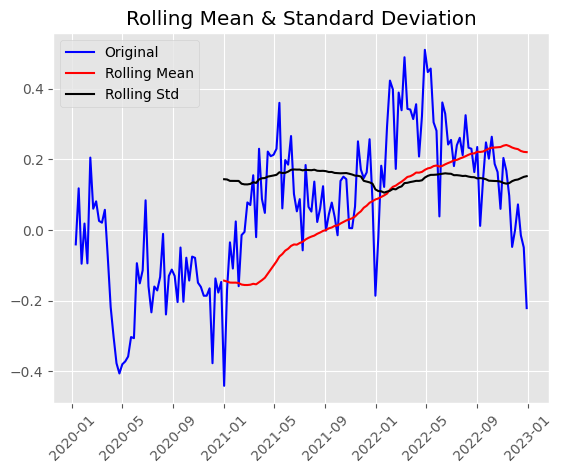

Results of Dickey-Fuller Test:
Test Statistic                  -1.823939
p-value                          0.368643
#Lags Used                       3.000000
Number of Observations Used    152.000000
Critical Value (1%)             -3.474121
Critical Value (5%)             -2.880750
Critical Value (10%)            -2.577013
dtype: float64


In [51]:
# dickey fuller test to check stationarity - 52 week window

# the below plot and data does not show stationarity (p value > 0.05, 
# as well as clear upward trend in the rolling mean)

check_stationarity(df, 52, df['bg_posts'])

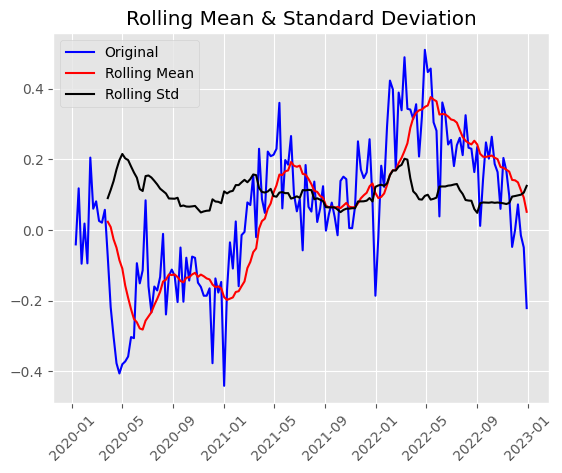

Results of Dickey-Fuller Test:
Test Statistic                  -1.823939
p-value                          0.368643
#Lags Used                       3.000000
Number of Observations Used    152.000000
Critical Value (1%)             -3.474121
Critical Value (5%)             -2.880750
Critical Value (10%)            -2.577013
dtype: float64


In [52]:
# dickey Fuller test to check stationarity - 12 week window
check_stationarity(df, 12, df['bg_posts'])

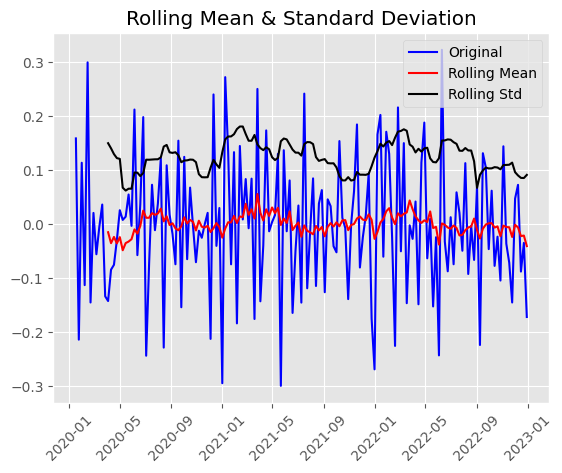

Results of Dickey-Fuller Test:
Test Statistic                -9.817304e+00
p-value                        5.454309e-17
#Lags Used                     2.000000e+00
Number of Observations Used    1.520000e+02
Critical Value (1%)           -3.474121e+00
Critical Value (5%)           -2.880750e+00
Critical Value (10%)          -2.577013e+00
dtype: float64


In [53]:
# this looks more stationary, implies one degree of differencing needed
# p value less than 0.05
check_stationarity(df.diff(), 12, df['bg_posts'].diff().dropna())

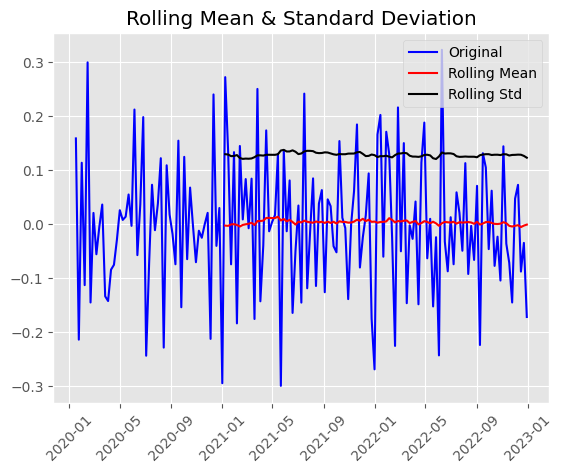

Results of Dickey-Fuller Test:
Test Statistic                -9.817304e+00
p-value                        5.454309e-17
#Lags Used                     2.000000e+00
Number of Observations Used    1.520000e+02
Critical Value (1%)           -3.474121e+00
Critical Value (5%)           -2.880750e+00
Critical Value (10%)          -2.577013e+00
dtype: float64


In [54]:
# this is the most stationary, implies one degree of differencing needed
# flat rolling mean and std, differenced data, 52 week period

check_stationarity(df.diff(), 52, df['bg_posts'].diff().dropna())

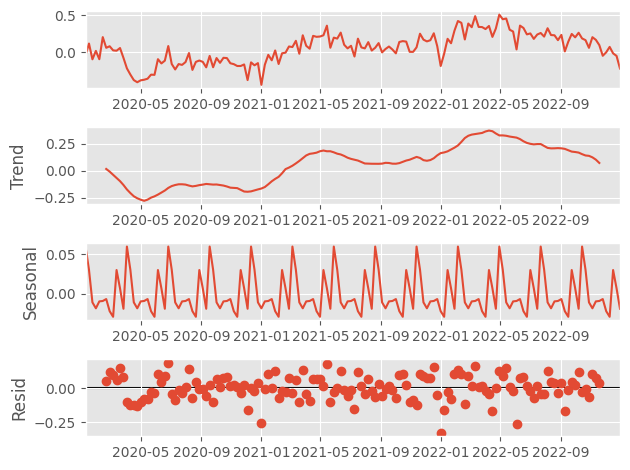

In [55]:
# with 12 period, see clear seasonal pattern and upward trend
# residuals look ok (evenly spread out)

sd = seasonal_decompose(df, period=12)
sd.plot()
plt.show()

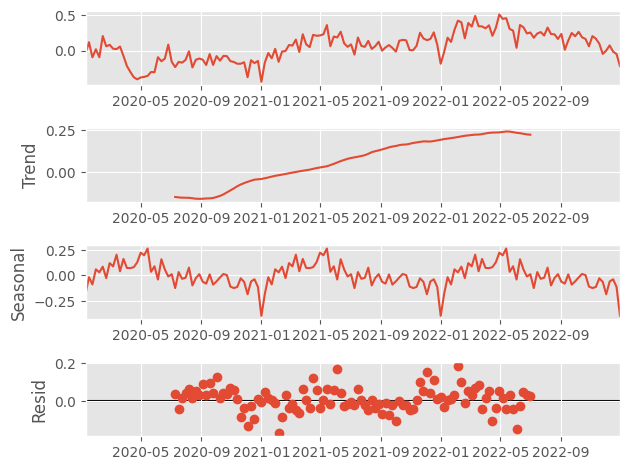

In [56]:
# upward trend even clearer with 52 week period
# 1y seasonality evident
# residuals look ok

sd = seasonal_decompose(df, period=52)
sd.plot()
plt.show()

<AxesSubplot: xlabel='date'>

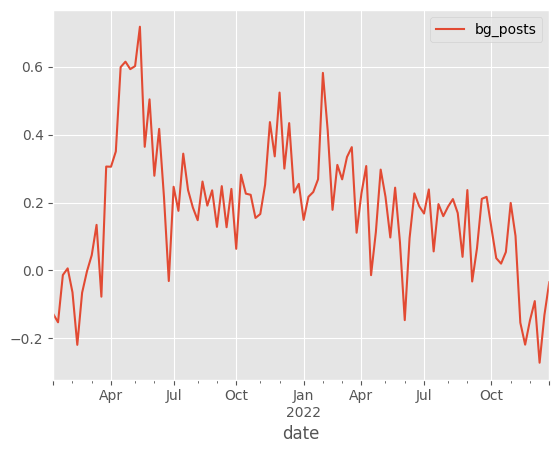

In [57]:
# visualizing 52 week shift / differencing

diff = df.dropna()
df_s_adj = diff - diff.shift(52)
df_s_adj = df_s_adj.dropna()
df_s_adj.plot()

In [58]:
# briefly looking at monthly data
df_monthly = df['bg_posts'].resample('MS').mean() # monthly frequency

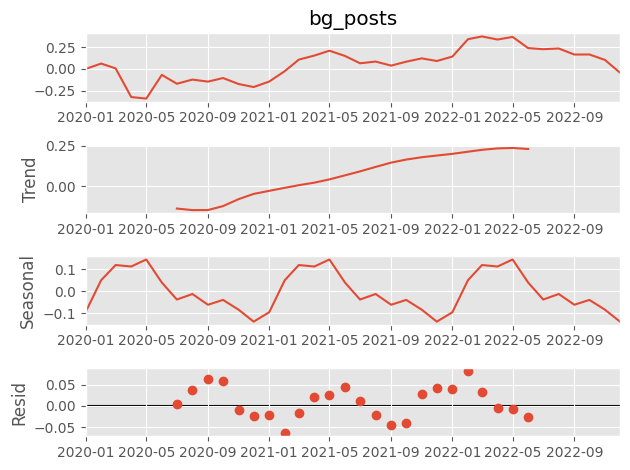

In [59]:
# smoother, but obvious seasonality and trend
# residuals not evenly spread out
# will stick with weekly data

sd = seasonal_decompose(df_monthly, period=12)
sd.plot()
plt.show()

#### Train Test Split

In [60]:
# weekly frequency
df = df['bg_posts'].resample('W-FRI').mean()
df = df.fillna(df.bfill())
df.head()

date
2020-01-10   -0.0407
2020-01-17    0.1180
2020-01-24   -0.0954
2020-01-31    0.0183
2020-02-07   -0.0943
Freq: W-FRI, Name: bg_posts, dtype: float64

In [61]:
df.head()

date
2020-01-10   -0.0407
2020-01-17    0.1180
2020-01-24   -0.0954
2020-01-31    0.0183
2020-02-07   -0.0943
Freq: W-FRI, Name: bg_posts, dtype: float64

In [62]:
# data needs to stay in chronological order so we cut off last 80% and set aside for test
cutoff = round(df.shape[0]*0.8) 
cutoff

125

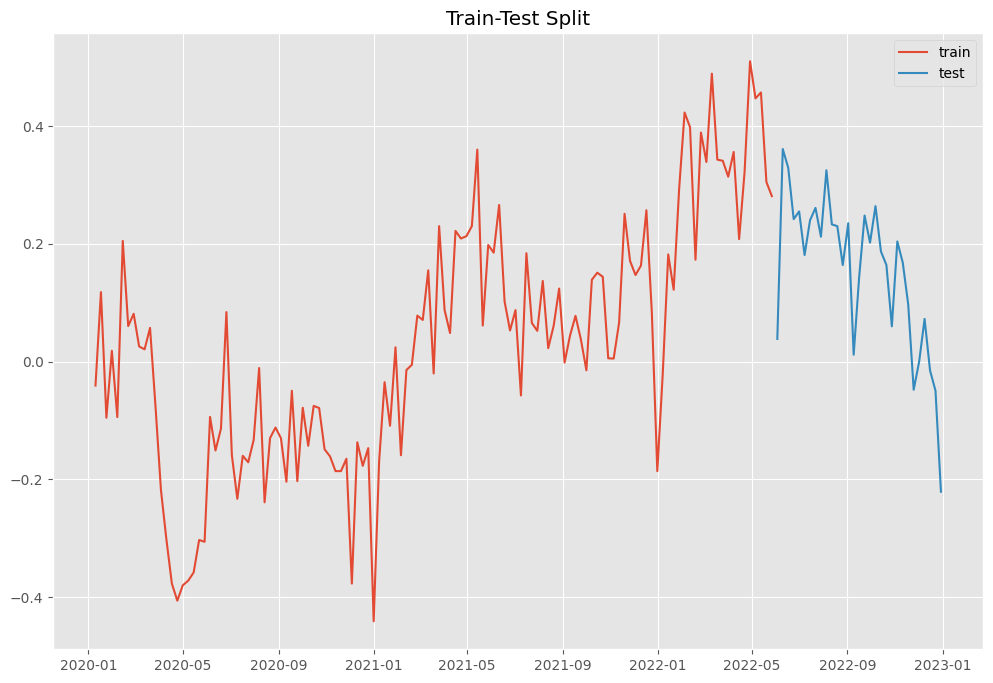

In [63]:
# train test split
train = df[:cutoff]
test = df[cutoff:]

# visualizing split
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [64]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (use 52 for frequency - yearly)
pdqs = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [65]:
results = []

for comb in pdq:
    
    for combs in pdqs:
        
        try:
            mod = sm.tsa.statespace.SARIMAX(endog=train,
                                            order=comb,
                                            seasonal_order=combs)
                                            #enforce_invertibility=False, 
                                            #enforce_stationarity=False)

            output = mod.fit()
            results.append([comb, combs, output.aic])
            
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        
        except: 
            continue

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30336D-01    |proj g|=  2.21640D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     18      1     0     0   2.216D-04  -1.303D-01
  F = -0.13033558207419482     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (0, 0, 0, 52): AIC Calculated=-30.583895518548708
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0      

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74406D-01    |proj g|=  1.82076D+00

At iterate    5    f=  1.23460D-01    |proj g|=  1.42205D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      5      8      1     0     0   1.422D-06   1.235D-01
  F =  0.12345977122923016     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (0, 1, 0, 52): AIC Calculated=32.86494280730754
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2

 This problem is unconstrained.



At iterate    5    f=  1.16355D-01    |proj g|=  2.47885D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     14      1     0     0   2.060D-06   1.163D-01
  F =  0.11626760271882947     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (0, 1, 1, 52): AIC Calculated=33.066900679707366
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30228D-01    |proj g|=  2.92109D-01

At iterate    5    f= -1.31298D-01    |proj g|=  6.19560D-03


 This problem is unconstrained.



At iterate   10    f= -1.31303D-01    |proj g|=  2.25053D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     13      1     0     0   2.251D-06  -1.313D-01
  F = -0.13130324053554132     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (1, 0, 0, 52): AIC Calculated=-28.825810133885334
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30141D-01    |proj g|=  1.34109D-01


 This problem is unconstrained.



At iterate    5    f= -1.44815D-01    |proj g|=  3.40531D-01

At iterate   10    f= -1.47219D-01    |proj g|=  2.25087D-02

At iterate   15    f= -1.47880D-01    |proj g|=  5.18565D-02

At iterate   20    f= -1.47972D-01    |proj g|=  2.71436D-03

At iterate   25    f= -1.47984D-01    |proj g|=  4.91952D-04

At iterate   30    f= -1.47986D-01    |proj g|=  8.33330D-04

At iterate   35    f= -1.47986D-01    |proj g|=  2.01390D-05

At iterate   40    f= -1.47986D-01    |proj g|=  3.14506D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     40     52      1     0     0   3.145D-04  -1.480D-01
  F = -0.147986011632

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25321D-01    |proj g|=  6.06807D-01

At iterate    5    f=  1.16347D-01    |proj g|=  1.83051D-02

At iterate   10    f=  1.16268D-01    |proj g|=  4.75664D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     13      1     0     0   4.757D-06   1.163D-01
  F =  0.11626760274175313     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (1, 1, 0, 52): AIC Calculated=33.066900685438284
RUN

 This problem is unconstrained.



At iterate    5    f=  1.16292D-01    |proj g|=  2.29097D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     13      1     0     0   2.960D-06   1.163D-01
  F =  0.11626760267195826     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (1, 1, 1, 52): AIC Calculated=35.066900667989565
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.40015D-01    |proj g|=  1.79239D+00

At iterate    5    f= -3.88258D-01    |proj g|=  1.11345D-02

  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -3.89186D-01    |proj g|=  2.17496D-01

At iterate   10    f= -3.90311D-01    |proj g|=  1.30881D-01

At iterate   15    f= -3.90847D-01    |proj g|=  1.56341D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     22      1     0     0   9.576D-06  -3.908D-01
  F = -0.39084680253926168     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 1) x (0, 0, 1, 52): AIC Calculated=-91.71170063481541
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -5.35136D-02    |proj g|=  2.09118D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     11      1     0     0   3.011D-06  -5.351D-02
  F =  -5.3513713181190442E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 1) x (0, 1, 0, 52): AIC Calculated=-9.37842829529761
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.28657D-03    |proj g|=  8.56108D-01


 This problem is unconstrained.



At iterate    5    f= -5.44331D-02    |proj g|=  9.48467D-03

At iterate   10    f= -5.46738D-02    |proj g|=  3.59791D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     19      1     0     0   9.585D-05  -5.471D-02
  F =  -5.4705796693222210E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (0, 1, 1, 52): AIC Calculated=-7.676449173305553
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.37491D-01    |proj g|=  1.77698D+00


 This problem is unconstrained.



At iterate    5    f= -3.85268D-01    |proj g|=  3.30323D-01

At iterate   10    f= -3.89754D-01    |proj g|=  1.20308D-02

At iterate   15    f= -3.89854D-01    |proj g|=  4.20405D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     23      1     0     0   1.453D-04  -3.899D-01
  F = -0.38985395692083374     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (1, 0, 0, 52): AIC Calculated=-91.46348923020844
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -3.88789D-01    |proj g|=  2.65533D-01

At iterate   10    f= -3.90247D-01    |proj g|=  1.32019D-02

At iterate   15    f= -3.90586D-01    |proj g|=  1.18349D-01

At iterate   20    f= -3.98868D-01    |proj g|=  1.20439D-01

At iterate   25    f= -3.99340D-01    |proj g|=  7.95934D-03

At iterate   30    f= -3.99743D-01    |proj g|=  8.17243D-03

At iterate   35    f= -3.99800D-01    |proj g|=  2.64415D-03

At iterate   40    f= -3.99809D-01    |proj g|=  2.53107D-03

At iterate   45    f= -3.99811D-01    |proj g|=  5.35354D-04

At iterate   50    f= -3.99811D-01    |proj g|=  8.55588D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.44938D-02    |proj g|=  8.52648D-03

At iterate   10    f= -5.47057D-02    |proj g|=  4.00261D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     20      1     0     0   1.676D-05  -5.471D-02
  F =  -5.4705797976268088E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (1, 1, 0, 52): AIC Calculated=-7.676449494067022
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.28657D-03    |proj g|=  8.56108D-01


 This problem is unconstrained.



At iterate    5    f= -5.47038D-02    |proj g|=  4.99822D-03

At iterate   10    f= -5.47058D-02    |proj g|=  1.59805D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     19      1     0     0   8.193D-06  -5.471D-02
  F =  -5.4705798034607893E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 1) x (1, 1, 1, 52): AIC Calculated=-5.676449508651974
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.44859D-01    |proj g|=  6.29470D-02

  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -6.66560D-01    |proj g|=  1.52124D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     11      1     0     0   8.299D-06  -6.666D-01
  F = -0.66656043252375829     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 0) x (0, 0, 1, 52): AIC Calculated=-162.64010813093958
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.10857D-01    |proj g|=  3.65096D+00

At iterate    5    f= -2.63981D-01    |proj g|=  1.31837D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      7     10      1     0     0   9.499D-06  -2.640D-01
  F = -0.26398285954330536     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 0) x (0, 1, 0, 52): AIC Calculated=-63.995714885826345
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =         

 This problem is unconstrained.



At iterate    5    f= -2.93750D-01    |proj g|=  6.83174D-03

At iterate   10    f= -2.94764D-01    |proj g|=  2.95567D-02

At iterate   15    f= -2.94846D-01    |proj g|=  9.51420D-03

At iterate   20    f= -2.94849D-01    |proj g|=  2.67480D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     21     50      1     0     0   2.443D-03  -2.948D-01
  F = -0.29484889975975648     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA (0, 1, 0) x (0, 1, 1, 52): AIC Calculated=-69.71222493993912
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.69169D-01    |proj g|=  2.22060D-01

At iterate    5    f= -6.69349D-01    |proj g|=  1.91081D-02


 This problem is unconstrained.



At iterate   10    f= -6.69359D-01    |proj g|=  1.39002D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     14      1     0     0   1.026D-05  -6.694D-01
  F = -0.66935936536947593     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (1, 0, 0, 52): AIC Calculated=-163.33984134236897
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.44857D-01    |proj g|=  1.70224D-01


 This problem is unconstrained.



At iterate    5    f= -6.67993D-01    |proj g|=  5.12155D-03

At iterate   10    f= -6.68072D-01    |proj g|=  1.29346D-01

At iterate   15    f= -6.71229D-01    |proj g|=  6.89097D-01

At iterate   20    f= -6.73085D-01    |proj g|=  4.17718D-02

At iterate   25    f= -6.73266D-01    |proj g|=  3.30818D-02

At iterate   30    f= -6.73309D-01    |proj g|=  9.24338D-03

At iterate   35    f= -6.73324D-01    |proj g|=  2.74653D-03

At iterate   40    f= -6.73328D-01    |proj g|=  1.12324D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     43     56      1     0     0   7.707D-03  -6.733D-01
  F = -0.673329639968

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.93201D-01    |proj g|=  4.54779D-01

At iterate    5    f= -2.94928D-01    |proj g|=  4.13321D-02

At iterate   10    f= -2.95175D-01    |proj g|=  1.78678D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     20      1     0     0   2.031D-04  -2.952D-01
  F = -0.29517551196993813     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (1, 1, 0, 52): AIC Calculated=-69.79387799248454
RUN

 This problem is unconstrained.



At iterate    5    f= -2.95171D-01    |proj g|=  2.49369D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   4.891D-05  -2.952D-01
  F = -0.29517554217785164     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (1, 1, 1, 52): AIC Calculated=-67.79388554446291
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.57717D-01    |proj g|=  1.42394D-02

At iterate    5    f= -7.57904D-01    |proj g|=  4.38417D-06

  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -7.74405D-01    |proj g|=  1.50779D-02

At iterate   10    f= -7.74587D-01    |proj g|=  7.38343D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     16      1     0     0   3.903D-06  -7.746D-01
  F = -0.77461886039079786     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 1) x (0, 0, 1, 52): AIC Calculated=-187.65471509769947
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.24111D-01    |proj g|=  1.30258D-01


 This problem is unconstrained.



At iterate    5    f= -3.26449D-01    |proj g|=  1.04741D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     28      1     0     0   2.943D-05  -3.265D-01
  F = -0.32645041414947379     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (0, 1, 0, 52): AIC Calculated=-77.61260353736844
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.24111D-01    |proj g|=  1.30258D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -3.46658D-01    |proj g|=  2.64935D-02

At iterate   10    f= -3.46994D-01    |proj g|=  8.60421D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     19      1     0     0   8.867D-05  -3.470D-01
  F = -0.34699354453199932     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (0, 1, 1, 52): AIC Calculated=-80.74838613299983
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.75079D-01    |proj g|=  6.00171D-01


 This problem is unconstrained.



At iterate    5    f= -7.76417D-01    |proj g|=  4.29865D-02

At iterate   10    f= -7.76424D-01    |proj g|=  3.45797D-03

At iterate   15    f= -7.76425D-01    |proj g|=  1.04886D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     24      1     0     0   9.823D-05  -7.764D-01
  F = -0.77642512660705654     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 0, 0, 52): AIC Calculated=-188.10628165176414
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate    5    f= -7.75471D-01    |proj g|=  1.82743D-02

At iterate   10    f= -7.75623D-01    |proj g|=  4.22176D-02

At iterate   15    f= -7.75765D-01    |proj g|=  1.72553D-01

At iterate   20    f= -7.77071D-01    |proj g|=  3.45101D-02

At iterate   25    f= -7.77872D-01    |proj g|=  2.75111D-02

At iterate   30    f= -7.77924D-01    |proj g|=  8.48773D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     37      1     0     0   4.228D-05  -7.779D-01
  F = -0.77792374471056025     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 0, 1, 52): AIC Calculated=-18

 This problem is unconstrained.



At iterate    5    f= -3.38359D-01    |proj g|=  9.10950D-02

At iterate   10    f= -3.45780D-01    |proj g|=  2.03647D-01

At iterate   15    f= -3.46304D-01    |proj g|=  1.42413D-01

At iterate   20    f= -3.46993D-01    |proj g|=  2.89858D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     29      1     0     0   4.909D-05  -3.470D-01
  F = -0.34699354280529021     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 1, 0, 52): AIC Calculated=-80.74838570132255
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -3.46987D-01    |proj g|=  4.45696D-03

At iterate   10    f= -3.46994D-01    |proj g|=  1.08847D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     15      1     0     0   1.088D-04  -3.470D-01
  F = -0.34699354206153382     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 1, 1, 52): AIC Calculated=-78.74838551538346
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.92135D-01    |proj g|=  6.44458D-02

At

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -7.12136D-01    |proj g|=  1.53269D-03

At iterate   10    f= -7.12148D-01    |proj g|=  2.21156D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   5.106D-07  -7.121D-01
  F = -0.71214777834557208     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 0) x (0, 0, 1, 52): AIC Calculated=-172.03694458639302
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.85015D-01    |proj g|=  4.45693D-02

A

 This problem is unconstrained.



At iterate   10    f= -2.85132D-01    |proj g|=  1.21847D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     47      2     0     0   3.654D-04  -2.851D-01
  F = -0.28513640039819937     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (0, 1, 0, 52): AIC Calculated=-67.28410009954985
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.85015D-01    |proj g|=  8.71798D-02


 This problem is unconstrained.



At iterate    5    f= -3.06873D-01    |proj g|=  3.79075D-02

At iterate   10    f= -3.08123D-01    |proj g|=  2.31745D-01

At iterate   15    f= -3.08608D-01    |proj g|=  9.42943D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     31      1     0     0   9.445D-03  -3.086D-01
  F = -0.30860848825155063     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (0, 1, 1, 52): AIC Calculated=-71.15212206288766
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -7.12912D-01    |proj g|=  9.80032D-03

At iterate   10    f= -7.13023D-01    |proj g|=  9.60482D-02

At iterate   15    f= -7.13087D-01    |proj g|=  4.30677D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     20      1     0     0   4.307D-05  -7.131D-01
  F = -0.71308666274848787     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 0, 0, 52): AIC Calculated=-172.27166568712195
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate    5    f= -7.12642D-01    |proj g|=  3.64987D-03

At iterate   10    f= -7.12726D-01    |proj g|=  3.44037D-02

At iterate   15    f= -7.12797D-01    |proj g|=  1.62683D-02

At iterate   20    f= -7.13263D-01    |proj g|=  2.70679D-02

At iterate   25    f= -7.13321D-01    |proj g|=  3.55878D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     35      1     0     0   3.746D-06  -7.133D-01
  F = -0.71332120758420203     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 0) x (1, 0, 1, 52): AIC Calculated=-170.3303018960505
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -3.07412D-01    |proj g|=  5.69696D-02

At iterate   10    f= -3.08585D-01    |proj g|=  9.49026D-03

At iterate   15    f= -3.08586D-01    |proj g|=  2.80122D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     25      1     0     0   2.801D-04  -3.086D-01
  F = -0.30858614909110871     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 1, 0, 52): AIC Calculated=-71.14653727277718
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -3.07175D-01    |proj g|=  1.06842D-02

At iterate   10    f= -3.08596D-01    |proj g|=  8.75696D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     22      1     0     0   7.085D-05  -3.086D-01
  F = -0.30859620163328683     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 1, 1, 52): AIC Calculated=-69.14905040832171
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.68321D-01    |proj g|=  1.17133D-01

At

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -7.86418D-01    |proj g|=  1.86704D-02

At iterate   10    f= -7.86515D-01    |proj g|=  9.93742D-02

At iterate   15    f= -7.86606D-01    |proj g|=  2.87944D-03

At iterate   20    f= -7.86680D-01    |proj g|=  6.71129D-02

At iterate   25    f= -7.87295D-01    |proj g|=  8.42778D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     35      1     0     0   1.244D-06  -7.873D-01
  F = -0.78729529386662012     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 1) x (0, 0, 1, 52): AIC Calculated=-188.82382346665503
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -3.32180D-01    |proj g|=  8.11722D-02

At iterate   10    f= -3.32239D-01    |proj g|=  1.36779D-02

At iterate   15    f= -3.32658D-01    |proj g|=  1.21738D-01

At iterate   20    f= -3.33849D-01    |proj g|=  1.74353D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     37      1     0     0   5.061D-04  -3.338D-01
  F = -0.33384962196864959     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (0, 1, 0, 52): AIC Calculated=-77.4624054921624


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.30751D-01    |proj g|=  1.05545D-01

At iterate    5    f= -3.51634D-01    |proj g|=  6.71982D-02

At iterate   10    f= -3.52008D-01    |proj g|=  2.82091D-03

At iterate   15    f= -3.52055D-01    |proj g|=  1.42643D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   20    f= -3.52058D-01    |proj g|=  4.89551D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     41      1     0     0   4.896D-04  -3.521D-01
  F = -0.35205828524004745     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (0, 1, 1, 52): AIC Calculated=-80.01457131001186
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.57395D-01    |proj g|=  1.81562D-01


 This problem is unconstrained.



At iterate    5    f= -7.87491D-01    |proj g|=  2.13594D-02

At iterate   10    f= -7.87852D-01    |proj g|=  6.87789D-02

At iterate   15    f= -7.87870D-01    |proj g|=  6.99365D-03

At iterate   20    f= -7.88014D-01    |proj g|=  3.48955D-02

At iterate   25    f= -7.88384D-01    |proj g|=  8.53556D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     33      1     0     0   8.522D-06  -7.884D-01
  F = -0.78838561286492148     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 1) x (1, 0, 0, 52): AIC Calculated=-189.09640321623036


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.68321D-01    |proj g|=  1.44700D-01

At iterate    5    f= -7.87294D-01    |proj g|=  1.37385D-02

At iterate   10    f= -7.87366D-01    |proj g|=  1.48198D-02

At iterate   15    f= -7.87830D-01    |proj g|=  3.48667D-01

At iterate   20    f= -7.88668D-01    |proj g|=  3.01477D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     28      1     0     0   8.286D-05  -7.887D-01
  F = -0.78866847498578152     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -3.51476D-01    |proj g|=  1.24170D-02

At iterate   10    f= -3.51636D-01    |proj g|=  9.54842D-04

At iterate   15    f= -3.51791D-01    |proj g|=  1.59407D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     28      1     0     0   1.530D-03  -3.518D-01
  F = -0.35179131625559085     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 1, 0, 52): AIC Calculated=-79.94782906389771
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -3.51675D-01    |proj g|=  1.01156D-02

At iterate   10    f= -3.51838D-01    |proj g|=  4.58925D-03

At iterate   15    f= -3.52010D-01    |proj g|=  3.71958D-03

At iterate   20    f= -3.52010D-01    |proj g|=  2.30783D-03

At iterate   25    f= -3.52014D-01    |proj g|=  1.47965D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     40      1     0     0   1.480D-03  -3.520D-01
  F = -0.35201397119637701     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 1, 1, 52): AIC Calculated=-78.00349279909425
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -7.60515D-01    |proj g|=  1.40414D-03

At iterate   10    f= -7.60517D-01    |proj g|=  6.44365D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     21      1     0     0   6.370D-05  -7.605D-01
  F = -0.76051674854223272     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (0, 0, 1, 52): AIC Calculated=-184.12918713555817
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.27189D-01    |proj g|=  5.68801D-02


 This problem is unconstrained.



At iterate    5    f= -3.27219D-01    |proj g|=  1.43492D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     33      2     0     0   3.642D-05  -3.272D-01
  F = -0.32722856600046407     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (0, 1, 0, 52): AIC Calculated=-77.80714150011602
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.27189D-01    |proj g|=  9.39548D-02


 This problem is unconstrained.



At iterate    5    f= -3.49211D-01    |proj g|=  8.35993D-02

At iterate   10    f= -3.49620D-01    |proj g|=  2.21098D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     20      1     0     0   7.356D-05  -3.496D-01
  F = -0.34962031526407511     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (0, 1, 1, 52): AIC Calculated=-81.40507881601877
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.61204D-01    |proj g|=  6.17060D-01


 This problem is unconstrained.



At iterate    5    f= -7.62524D-01    |proj g|=  1.78662D-02

At iterate   10    f= -7.62545D-01    |proj g|=  1.25110D-03

At iterate   15    f= -7.62545D-01    |proj g|=  8.27360D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     25      1     0     0   8.274D-05  -7.625D-01
  F = -0.76254473973535364     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (1, 0, 0, 52): AIC Calculated=-184.63618493383842
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate    5    f= -7.61586D-01    |proj g|=  2.01420D-02

At iterate   10    f= -7.61620D-01    |proj g|=  8.27409D-02

At iterate   15    f= -7.61923D-01    |proj g|=  4.22422D-02

At iterate   20    f= -7.62716D-01    |proj g|=  3.53332D-01

At iterate   25    f= -7.63446D-01    |proj g|=  5.10420D-02

At iterate   30    f= -7.63849D-01    |proj g|=  1.07155D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f= -7.63851D-01    |proj g|=  3.60863D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     59      2     0     0   3.609D-05  -7.639D-01
  F = -0.76385138390940266     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (1, 0, 1, 52): AIC Calculated=-182.96284597735067
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.27404D-01    |proj g|=  1.27670D+00


 This problem is unconstrained.



At iterate    5    f= -3.44602D-01    |proj g|=  3.84346D-02

At iterate   10    f= -3.48284D-01    |proj g|=  2.91025D-01

At iterate   15    f= -3.48969D-01    |proj g|=  8.41111D-02

At iterate   20    f= -3.49620D-01    |proj g|=  1.31152D-03

At iterate   25    f= -3.49620D-01    |proj g|=  2.57442D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     33      1     0     0   2.574D-04  -3.496D-01
  F = -0.34962031634105778     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (1, 1, 0, 52): AIC Calculated=-81.40507908526445
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -3.49507D-01    |proj g|=  9.11287D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   10    f= -3.49620D-01    |proj g|=  5.24570D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     28      1     0     0   5.246D-05  -3.496D-01
  F = -0.34962032020084194     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (1, 1, 1, 52): AIC Calculated=-79.40508005021049
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.57617D-01    |proj g|=  2.14209D-02

At iterate    5    f= -7.57914D-01    |proj g|=  2.23474D-02

At

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -7.74996D-01    |proj g|=  3.58331D-03

At iterate   10    f= -7.75084D-01    |proj g|=  1.20018D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     26      1     0     0   1.200D-04  -7.751D-01
  F = -0.77508357721127230     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (0, 0, 1, 52): AIC Calculated=-185.77089430281808
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.30651D-01    |proj g|=  1.50904D-01

At iterate    5    f= -3.30933D-01    |proj g|=  1.44408D-02

           * * *

Tit   = total number of iterations
Tnf   = to

 This problem is unconstrained.



At iterate    5    f= -3.49931D-01    |proj g|=  3.41560D-02

At iterate   10    f= -3.50639D-01    |proj g|=  2.48476D-03

At iterate   15    f= -3.50754D-01    |proj g|=  2.78604D-04
  ys=-2.565E-08  -gs= 1.048E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     32      1     1     0   7.441D-04  -3.508D-01
  F = -0.35075384984596791     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (0, 1, 1, 52): AIC Calculated=-79.68846246149198
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At 

 This problem is unconstrained.



At iterate    5    f= -7.76832D-01    |proj g|=  2.03484D-02

At iterate   10    f= -7.76891D-01    |proj g|=  2.72395D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     19      1     0     0   3.163D-05  -7.769D-01
  F = -0.77689402491460202     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (1, 0, 0, 52): AIC Calculated=-186.2235062286505
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.57617D-01    |proj g|=  1.44600D-01


 This problem is unconstrained.



At iterate    5    f= -7.75744D-01    |proj g|=  7.48856D-02

At iterate   10    f= -7.75970D-01    |proj g|=  1.48483D-02

At iterate   15    f= -7.76195D-01    |proj g|=  1.71107D-01

At iterate   20    f= -7.76677D-01    |proj g|=  1.76595D-02

At iterate   25    f= -7.77647D-01    |proj g|=  6.27061D-02

At iterate   30    f= -7.78251D-01    |proj g|=  1.01866D-02

At iterate   35    f= -7.78258D-01    |proj g|=  2.06073D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     41      1     0     0   2.061D-04  -7.783D-01
  F = -0.77825761657084369     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.25949D-01    |proj g|=  1.29361D+00

At iterate    5    f= -3.44159D-01    |proj g|=  8.10356D-02

At iterate   10    f= -3.48266D-01    |proj g|=  2.68248D-02

At iterate   15    f= -3.50331D-01    |proj g|=  2.06373D-01

At iterate   20    f= -3.50731D-01    |proj g|=  1.39927D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     66      2     0     0   8.724D-05  -3.508D-01
  F = -0.35075385560620764     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (1, 1, 0, 52): AIC Calculated=-79.68846390155191
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.30651D-01    |proj g|=  1.50904D-01


 This problem is unconstrained.



At iterate    5    f= -3.50499D-01    |proj g|=  6.63059D-02

At iterate   10    f= -3.50576D-01    |proj g|=  2.25389D-02

At iterate   15    f= -3.50697D-01    |proj g|=  4.40839D-02

At iterate   20    f= -3.50754D-01    |proj g|=  2.00342D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     30      1     0     0   2.003D-04  -3.508D-01
  F = -0.35075381335349554     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (1, 1, 1, 52): AIC Calculated=-77.68845333837389


In [66]:
results_df = pd.DataFrame(results, columns=['pdq', 'pdqs', 'aic'])
results_df.loc[results_df['aic'].idxmin()]

order = results_df.iloc[results_df.loc[results_df['aic'].idxmin()].name]['pdq']
seasonal_order = results_df.iloc[results_df.loc[results_df['aic'].idxmin()].name]['pdqs']

In [67]:
sari_mod = sm.tsa.statespace.SARIMAX(train,
                                     order=order,
                                     seasonal_order=seasonal_order).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.57395D-01    |proj g|=  1.81562D-01


 This problem is unconstrained.



At iterate    5    f= -7.87491D-01    |proj g|=  2.13594D-02

At iterate   10    f= -7.87852D-01    |proj g|=  6.87789D-02

At iterate   15    f= -7.87870D-01    |proj g|=  6.99365D-03

At iterate   20    f= -7.88014D-01    |proj g|=  3.48955D-02

At iterate   25    f= -7.88384D-01    |proj g|=  8.53556D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     33      1     0     0   8.522D-06  -7.884D-01
  F = -0.78838561286492148     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [68]:
# Fit the model and print results
print(sari_mod.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            bg_posts   No. Observations:                  125
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 52)   Log Likelihood                  98.548
Date:                             Mon, 06 Feb 2023   AIC                           -189.096
Time:                                     00:37:55   BIC                           -177.783
Sample:                                 01-10-2020   HQIC                          -184.500
                                      - 05-27-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9536      0.031     30.506      0.000       0.892       1.015
ma.L1         -0.4428      

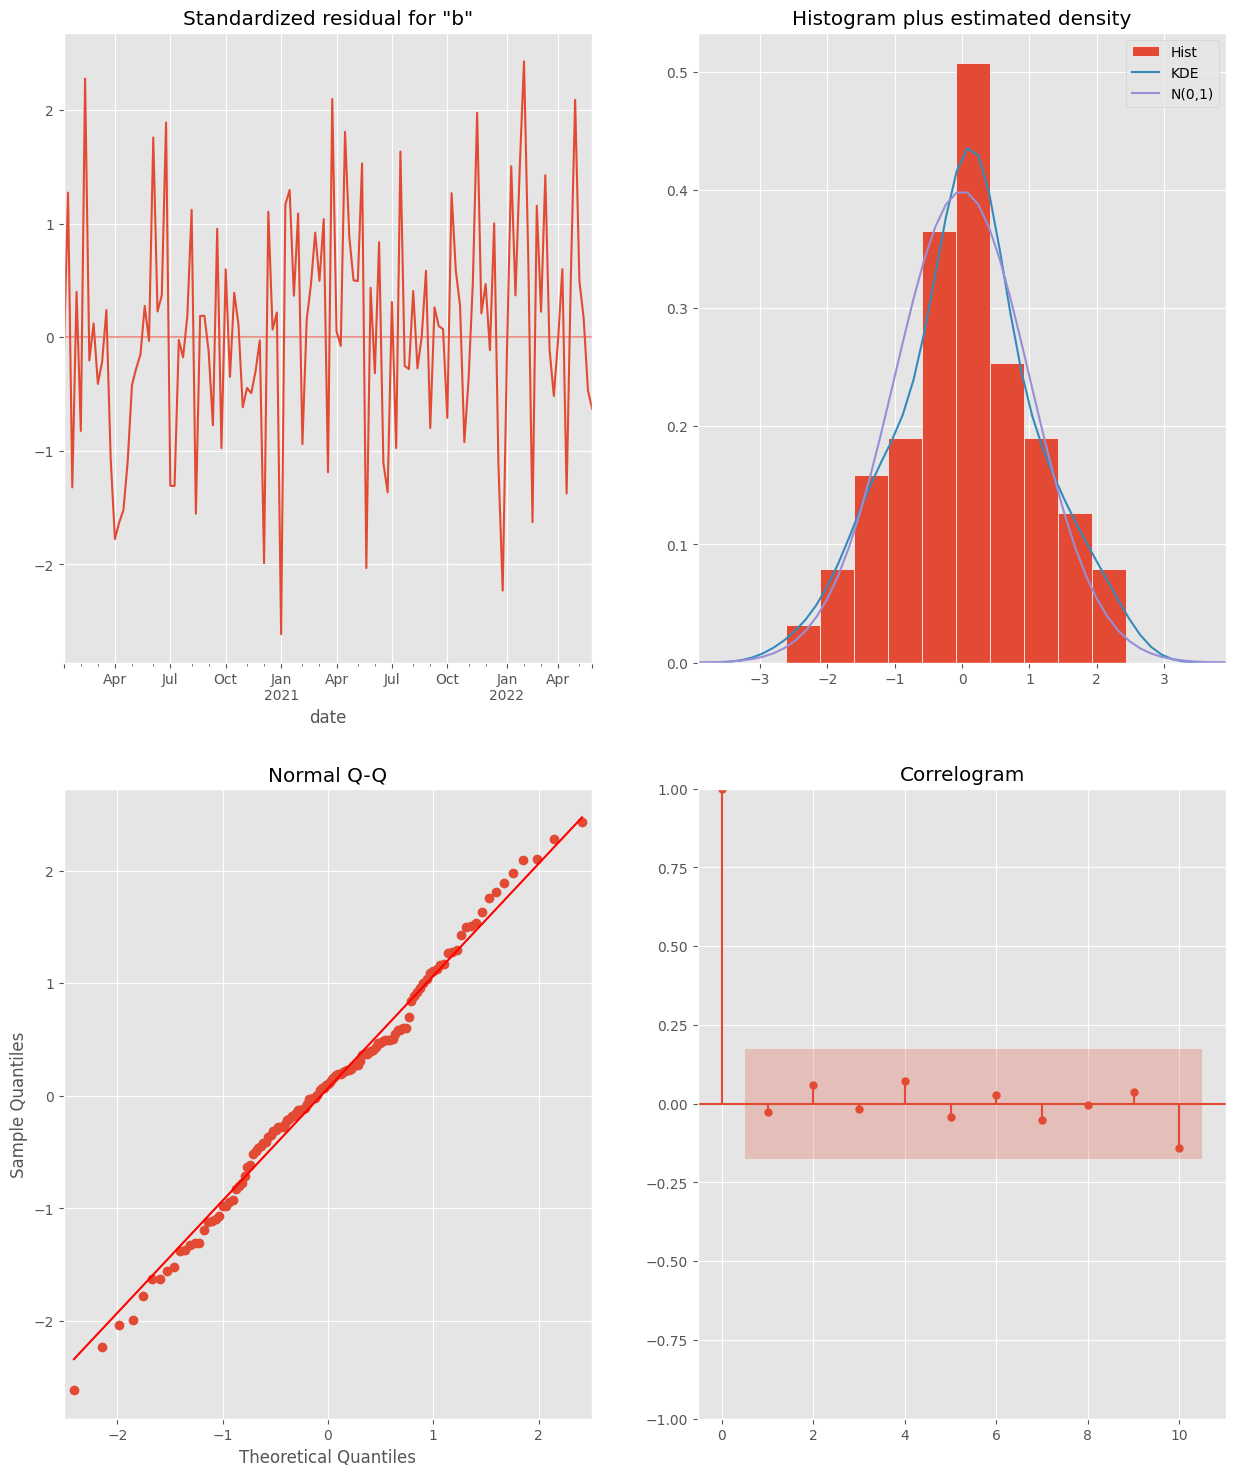

<Figure size 640x480 with 0 Axes>

In [69]:
sari_mod.plot_diagnostics(figsize=(15, 18))
plt.show()
plt.savefig('assets/timeseries_diagnostics.png')

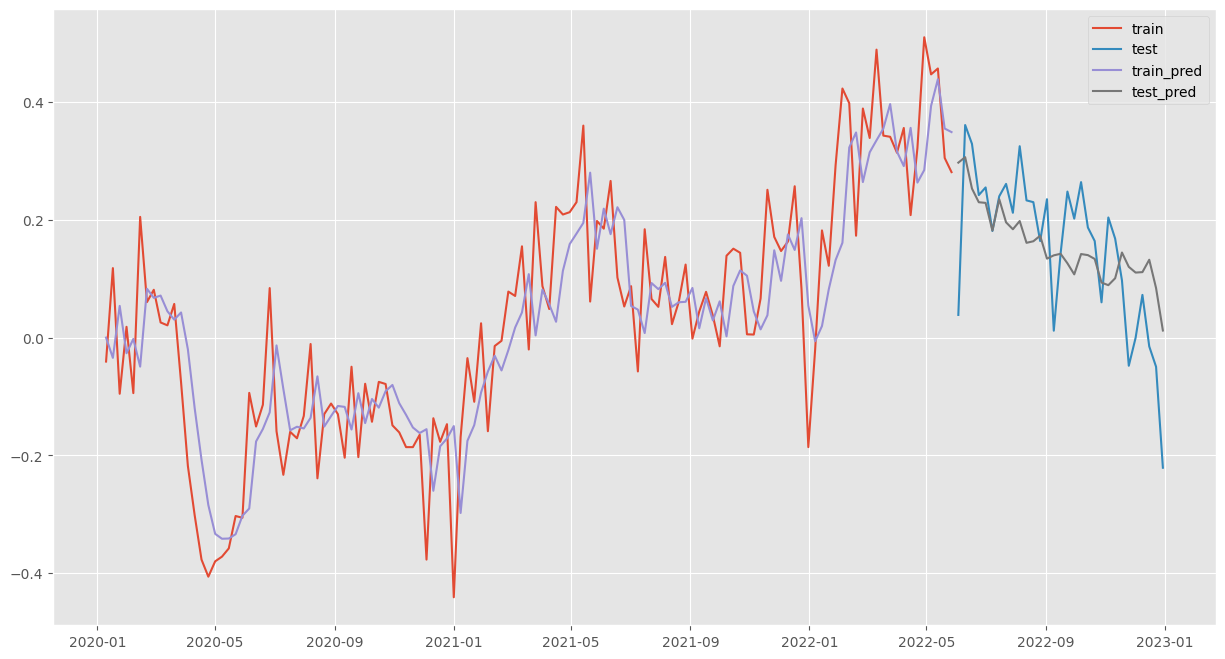

In [70]:
y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1], 
                              typ='levels', dynamic=True)

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train, label='train')
ax.plot(test, label='test') # valid
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend()

plt.savefig('assets/timeseries_validation.png');

In [71]:
print("MSE, train: ", str(np.sqrt(mean_squared_error(train, y_hat_train))))

error = np.sqrt(mean_squared_error(test, y_hat_test))
print("MSE, test: ", str(error))

MSE, train:  0.10948173385934748
MSE, test:  0.10358723019747416


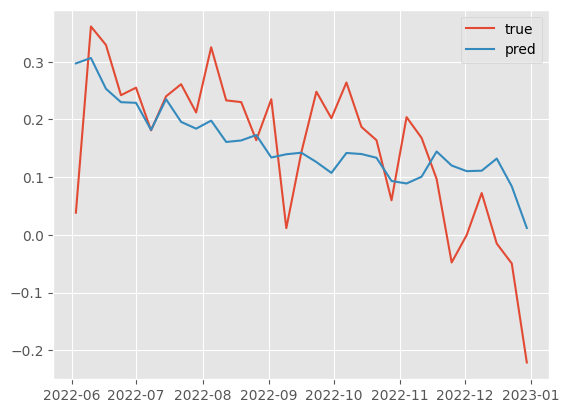

In [72]:
# Let's zoom in on test
fig, ax = plt.subplots()

ax.plot(test, label='true')
ax.plot(y_hat_test, label='pred')

plt.legend();

#### Forecast

In [73]:
# running model on full series
sari_mod_final = sm.tsa.statespace.SARIMAX(df,
                                           order=order,
                                           seasonal_order=seasonal_order).fit()

forecast = sari_mod_final.forecast(steps=52, dynamic=True)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.02648D-01    |proj g|=  4.23456D-01

At iterate    5    f= -8.12667D-01    |proj g|=  2.18992D-02

At iterate   10    f= -8.12701D-01    |proj g|=  7.55498D-02

At iterate   15    f= -8.12755D-01    |proj g|=  1.08171D-03

At iterate   20    f= -8.12767D-01    |proj g|=  1.90906D-02

At iterate   25    f= -8.12834D-01    |proj g|=  1.09827D-02

At iterate   30    f= -8.12835D-01    |proj g|=  1.40507D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

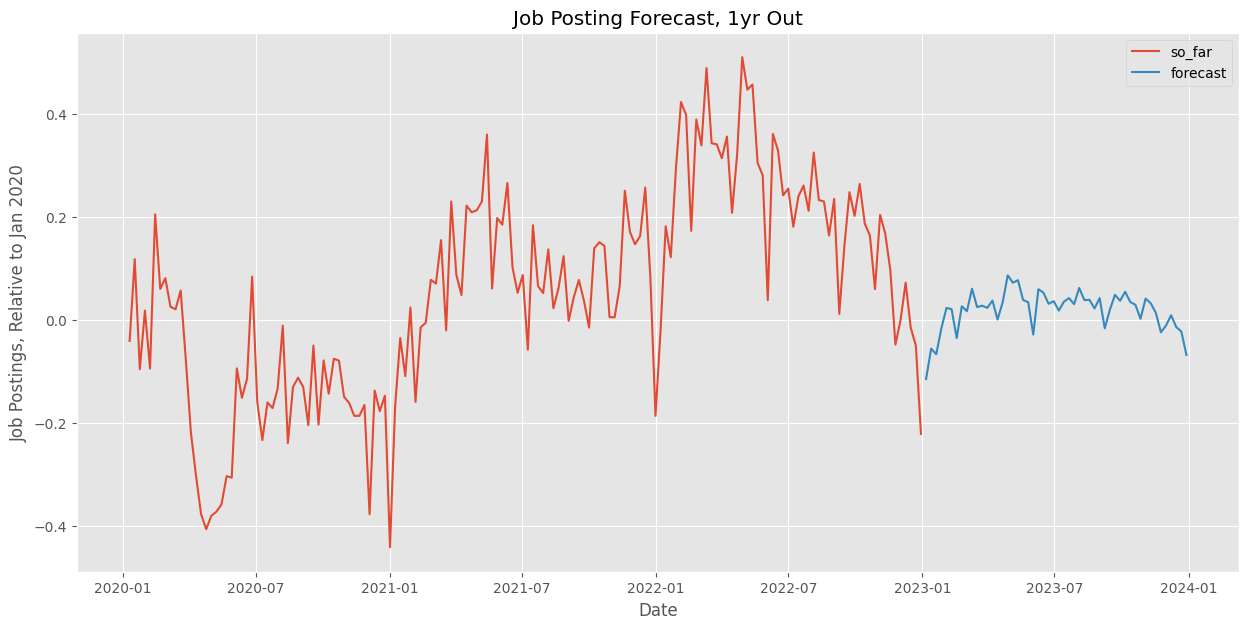

In [74]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(df, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('Job Posting Forecast, 1yr Out')
ax.set_xlabel('Date')
ax.set_ylabel('Job Postings, Relative to Jan 2020')

plt.legend()

plt.savefig('assets/job_forecast.png');

In [75]:
# storing preds in dataframe
forecast_df = pd.DataFrame(forecast).reset_index()
forecast_df.columns = ['date', 'prediction']
forecast_df.to_csv('data/jobs_forecast.csv')

In [76]:
forecast_df.head()

,date,prediction
0,2023-01-06,-0.114719
1,2023-01-13,-0.055429
2,2023-01-20,-0.066422
3,2023-01-27,-0.015941
4,2023-02-03,0.023354


<AxesSubplot: >

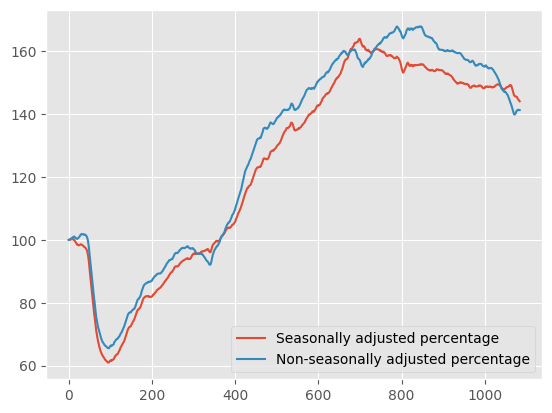

In [77]:
# indeed

indeed_jobs[['Date', 'Seasonally adjusted percentage', 'Non-seasonally adjusted percentage']].plot()

# Supervised Models

### Data Prep

In [79]:
layoffs_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2110 entries, 0 to 2109
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              2110 non-null   object 
 1   location             2110 non-null   object 
 2   industry             2109 non-null   object 
 3   total_laid_off       1453 non-null   float64
 4   percentage_laid_off  1420 non-null   float64
 5   date                 2110 non-null   object 
 6   stage                2104 non-null   object 
 7   country              2110 non-null   object 
 8   funds_raised         2110 non-null   float64
dtypes: float64(3), object(6)
memory usage: 148.5+ KB


In [80]:
layoffs_raw.isnull().sum()

company                  0
location                 0
industry                 1
total_laid_off         657
percentage_laid_off    690
date                     0
stage                    6
country                  0
funds_raised             0
dtype: int64

In [81]:
# converting to numeric type
layoffs_raw['funds_raised'] = pd.to_numeric(layoffs_raw['funds_raised'], 
                                            errors='coerce')

In [82]:
# replacing missing value of funds raised with median
layoffs_raw['funds_raised'].fillna(layoffs_raw['funds_raised'].median(), 
                                   inplace=True)

In [83]:
# converting to datetime, adding column for year
layoffs_raw['date'] = pd.to_datetime(layoffs_raw['date'])
layoffs_raw['year'] = [day.year for day in layoffs_raw['date']]

In [84]:
# getting rid of nans (very few for this subset)
layoffs_raw = layoffs_raw.dropna(subset=['industry', 'stage']).reset_index(drop=True)

In [85]:
# checking for duplicates
layoffs_raw[layoffs_raw.duplicated()]

In [86]:
# after some research, it appears there were indeed two rounds of layoffs
# for Cazoo
layoffs_raw[layoffs_raw.company=='cazoo']

In [87]:
# second round of layoffs were on 9/8/2022
# source: https://sifted.eu/articles/cazoo-layoffs-european-union/ 

layoffs_raw.iloc[1245]['date'] = '2022-09-08' # adding correct value

In [88]:
# layoffs_sorted = layoffs_raw[['company', 'funds_raised', 'date']].sort_values(by='date')
# # funds raised in first round of layoffs and
# #year of first layoffs

# ff = layoffs_sorted.drop_duplicates(subset=['company'], keep='first')
# ff['year_fr'] = [day.year for day in ff.date]
# ff.columns=['company', 'funds_raised_fr', 'date_fr', 'year_fr']

# ff[ff.company=='uber']

In [89]:
# list of companies that had more than one round of layoffs
mult_layoffs = list(layoffs_raw.company.value_counts()[layoffs_raw.company.value_counts() > 1].index)

In [90]:
len(mult_layoffs)

In [91]:
data_classification = layoffs_raw.drop(['total_laid_off', 'percentage_laid_off', 
                                        'date', 'year'], axis=1)

grouped = data_classification.groupby(by=['company', 'location', 'industry', 
                                          'stage', 'country']).sum().reset_index()

In [92]:
data_classification['multiple'] = [True if co in mult_layoffs else False 
                                   for co in data_classification.company]
data_classification.tail()

In [93]:
#layoffs_raw[layoffs_raw.date>'22-01-2023'].to_csv('extra_cos.csv')

### Classification with Layoffs.fyi data

In [94]:
layoffs_sorted[layoffs_sorted.company=='uber']

In [95]:
ff.head() # can reset index if needed

In [96]:
funds = data_classification[['company', 'funds_raised']].groupby(by='company').sum().reset_index()
display(funds.head())

In [97]:
# data_classification['multiple'] = [True if co in mult_layoffs else False 
#                                    for co in data_classification.company]

In [98]:
layoffs_occurrance = data_classification[['company', 'multiple']].groupby(by='company').sum().reset_index()
layoffs_occurrance['multiple'] = [1 if val > 0 else 0 for val in layoffs_occurrance['multiple']]
layoffs_occurrance

In [99]:
df1 = pd.pivot_table(data_classification, 
                     index=['company', 'location', 'stage', 'industry', 'country'], 
                     values='funds_raised', aggfunc=np.sum).reset_index()

df1 = df1.sort_values(by='stage').reset_index(drop=True)
df1

In [100]:
# duplicated companies
dup = df1[df1.duplicated(subset='company')]

In [101]:
# checking that index location is same in dup and df1

In [102]:
dup[dup.company=='ebanx']

In [103]:
df1[df1.company=='ebanx']

In [104]:
# dropping duplicated where stage is Unknown
df1 = df1.drop(index=list(dup[dup['stage']=='Unknown'].index)).reset_index(drop=True)

In [105]:
df1.tail(11)

In [106]:
# dropping all duplicates, resetting funds_raised to sum of funds
# raised during all layoffs per company, retagging target 

df_final = df1.drop_duplicates(subset='company', keep='last').reset_index(drop=True)
df_final['funds_raised'] = [float(funds['funds_raised'][funds['company']==co]) 
                            for co in df_final['company']]
df_final['multiple'] = [int(layoffs_occurrance['multiple'][layoffs_occurrance['company']==co]) 
                        for co in df_final['company']]

In [107]:
sum(df_final.company.duplicated())

In [108]:
df_final.info()

In [109]:
# adding in data on first round of funding
df_final = df_final.merge(ff, how='left', on='company')
df_final

#### Train Test Split

In [110]:
X = df_final.drop(['multiple', 'company', 'funds_raised', 'date_fr'], axis=1)
y = df_final['multiple']

In [111]:
y.value_counts(normalize=True) # fairly imbalanced, will need to address

In [112]:
X.head()

In [113]:
print(len(set(X['location'])))
print(len(set(X['country'])))

In [114]:
# train test split & preprocess
cat_columns = ['industry', 'stage'] #'location'

X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, \
y_train, y_test = train_test_preprocess(X, y, cat_columns)

In [115]:
X_train_processed.shape

#### Baseline

In [116]:
# baseline
baseline_model = LogisticRegression(random_state=42) 
baseline_model.fit(X_train_scaled, y_train)

In [117]:
# baseline is no better than random guessing, & very low recall
y_hat_train = baseline_model.predict(X_train_scaled)
y_hat_test = baseline_model.predict(X_test_scaled)

print_scores(y_train, y_hat_train, y_test, y_hat_test) 

In [118]:
#### SMOTE to deal with class imbalance

In [119]:
print(y_train.value_counts())

sm = SMOTE(random_state = 42)
X_train_res, y_train_res = sm.fit_resample(X_train_processed, y_train)
X_train_res_scaled, y_train_res_scaled = sm.fit_resample(X_train_scaled, y_train)

print(pd.Series(y_train_res).value_counts()) 

#### Model Tuning

In [120]:
dtc = DecisionTreeClassifier(random_state=42)#, class_weight='balanced')

dtc.fit(X_train_res, y_train_res)
y_hat_train = dtc.predict(X_train_res)
y_hat_test = dtc.predict(X_test_processed)

print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

In [121]:
pipe = Pipeline([('classifier' , DecisionTreeClassifier(random_state=42))])

param_grid = [{
    
    'classifier' : [DecisionTreeClassifier(random_state=42)],
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__max_depth': [None, 1, 5, 10],
    'classifier__min_samples_split': [2, 5, 15],
    'classifier__max_features': [None, 10, 100, 'auto']
    #'classifier__class_weight': [None, 'balanced'] # only need w/o SMOTE
}]

dtc_grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='f1')

dtc_best = dtc_grid.fit(X_train_res, y_train_res)

In [122]:
y_hat_train = dtc_best.predict(X_train_res)
y_hat_test = dtc_best.predict(X_test_processed)

print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

In [123]:
xgb = XGBClassifier(random_state=42)#, scale_pos_weight=1.5)
xgb.fit(X_train_res, y_train_res)
y_hat_train = xgb.predict(X_train_res)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

In [124]:
xgb = XGBClassifier(random_state=42, scale_pos_weight=7)
xgb.fit(X_train_processed, y_train)
y_hat_train = xgb.predict(X_train_processed)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

In [125]:
from xgboost import plot_importance
plot_importance(xgb, max_num_features=20, importance_type='gain', 
                show_values=False)
plt.show()

In [126]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train_processed, y_train)
y_hat_train = rf.predict(X_train_processed)
y_hat_test = rf.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

In [127]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)
y_hat_train = rf.predict(X_train_res)
y_hat_test = rf.predict(X_test_processed)

print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

In [128]:
# Logistic Regression with balanced class weight - big improvement
lr = LogisticRegression(random_state=42, class_weight='balanced') 

lr.fit(X_train_scaled, y_train)

y_hat_train = lr.predict(X_train_scaled)
y_hat_test = lr.predict(X_test_scaled)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

In [129]:
lr2 = LogisticRegression(random_state=42)
lr2.fit(X_train_res_scaled, y_train_res_scaled)

y_hat_train = lr2.predict(X_train_res_scaled)
y_hat_test = lr2.predict(X_test_scaled)

print_scores(y_train_res_scaled, y_hat_train, y_test, y_hat_test)

In [130]:
# param tuning logistic regression model
pipe = Pipeline([('classifier' , LogisticRegression(random_state=42))])

param_grid = [{
    
    'classifier' : [LogisticRegression(random_state=42)],
    'classifier__C': [0, 0.5, 1, 2, 1e12],
    'classifier__solver': ['newton-cg', 'liblinear', 'lbfgs', 'saga'],
    'classifier__penalty': ['l1', 'l2', None],
   
}]

lr_grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='recall')

lr_best = lr_grid.fit(X_train_res_scaled, y_train_res_scaled)

This model correctly identifies 61% of companies that had more than one round of layoffs (recall).
When it predicts a company had multiple layoffs, it is correct 41% of the time (precision).

In [131]:
y_hat_train = lr_best.predict(X_train_res_scaled) # or scaled
y_hat_test = lr_best.predict(X_test_scaled) # or scaled

print_scores(y_train_res_scaled, y_hat_train, y_test, y_hat_test)

In [132]:
lr_best.best_params_

In [133]:
best_lr = LogisticRegression(random_state=42, C=0.5, penalty='l1', solver='liblinear')
best_lr.fit(X_train_res_scaled, y_train_res_scaled)

In [134]:
## Top coefficients

coef_df = pd.DataFrame(best_lr.coef_, columns=X_train_res_scaled.columns).transpose()

coef_df.columns=['coef']
coef_df['coef_abs'] = abs(coef_df['coef'])

coef_df.sort_values(by='coef_abs', ascending=False)[:20]

In [135]:
feat_importance = coef_df.sort_values(by='coef_abs', ascending=False)[:20]

y=np.array(feat_importance['coef'])
color=np.array(['rgb(255,255,255)']*y.shape[0])
color[y<0]='rgb(204,204, 205)'
color[y>=0]='rgb(130, 0, 0)'

data=[dict(type='bar',
       y=y,
       marker=dict(color=color.tolist()) 
      )]


fig = px.bar(feat_importance['coef'], color=data[0]['marker']['color'])
fig.show()

In [136]:
fig = px.bar(feat_importance['coef'])
fig.show()

In [137]:
### PREDICTION EXAMPLE ###
example_company = ['Austin', 'Stage B', 'Real Estate', 'United States', 50.0]

###  Classification with Crunchbase Data

In [138]:
df_class_final = df_classification_cb.drop(['Headquarters Regions', 'Founded Date'], axis=1)

In [139]:
df_class_final.info()

In [140]:
df_class_final['multiple'] = [1 if co in mult_layoffs else 0 for co in df_class_final.company]

In [141]:
df_class_final = df_class_final[~df_class_final.duplicated()]

In [142]:
df2 = df_class_final.drop(['Estimated Revenue Range', 
                           'total_laid_off', 
                           'percentage_laid_off'], axis=1)

In [143]:
# dropping duplicates
df2 = df2[~df2.duplicated()]

In [144]:
# sorting from oldest to newest
df2 = df2.sort_values(by='date').reset_index(drop=True)

# dropping duplicated where stage is Unknown
dup = df2[df2.duplicated(subset='company')]
df2 = df2.drop(index=list(dup[dup['stage']=='Unknown'].index)).reset_index(drop=True)

# keeping rows with most recent record
df2 = df2.drop_duplicates(subset='company', keep='last').reset_index(drop=True)

In [145]:
df2.multiple.value_counts(normalize=True)

#### Train Test Split

In [146]:
X = df2.drop(['multiple', 'company', 'date'], axis=1)
y = df2['multiple']

In [147]:
X.head()

In [148]:
# train test split & preprocess
cat_columns = ['industry', 'stage', 'Number of Employees', 
               'Operating Status', 'country']

X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, \
y_train, y_test = train_test_preprocess(X, y, cat_columns)

In [149]:
print(y_train.value_counts())

sm = SMOTE(random_state = 42)
X_train_res, y_train_res = sm.fit_resample(X_train_processed, y_train)
X_train_res_scaled, y_train_res_scaled = sm.fit_resample(X_train_scaled, y_train)

print(pd.Series(y_train_res).value_counts()) 

#### Logistic Regression

In [150]:
lr2 = LogisticRegression(random_state=42, solver='liblinear')
lr2.fit(X_train_res_scaled, y_train_res_scaled)

y_hat_train = lr2.predict(X_train_res_scaled)
y_hat_test = lr2.predict(X_test_scaled)

print_scores(y_train_res_scaled, y_hat_train, y_test, y_hat_test)

In [151]:
## Top coefficients - this list makes a lot of sense

coef_df = pd.DataFrame(lr2.coef_, columns=X_train_res_scaled.columns).transpose()
#coef_df.to_csv('coef_logreg.csv')

coef_df.columns=['coef']
coef_df['coef_abs'] = abs(coef_df['coef'])

coef_df.sort_values(by='coef_abs', ascending=False)[:20]

In [152]:
# param tuning logistic regression model
pipe = Pipeline([('classifier' , LogisticRegression(random_state=42))])

param_grid = [{
    
    'classifier' : [LogisticRegression(random_state=42)],
    'classifier__C': [0, 0.5, 1, 2, 1e12],
    'classifier__solver': ['newton-cg', 'liblinear', 'lbfgs', 'saga'],
    'classifier__penalty': ['l1', 'l2', None],
   
}]

lr_grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='recall')

lr_best = lr_grid.fit(X_train_res_scaled, y_train_res_scaled)

In [153]:
lr_best.best_params_

In [154]:
y_hat_train = lr_best.predict(X_train_res_scaled) # or scaled
y_hat_test = lr_best.predict(X_test_scaled) # or scaled

print_scores(y_train_res_scaled, y_hat_train, y_test, y_hat_test)

In [155]:
lr3 = LogisticRegression(random_state=42, class_weight='balanced')
lr3.fit(X_train_scaled, y_train)

y_hat_train = lr2.predict(X_train_scaled)
y_hat_test = lr2.predict(X_test_scaled)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

In [156]:
X_train_processed.head()

In [157]:
lr3 = LogisticRegression(random_state=42, class_weight='balanced')
lr3.fit(X_train_scaled, y_train)

y_hat_train = lr3.predict(X_train_scaled)
y_hat_test = lr3.predict(X_test_scaled)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

In [158]:
lr4 = LogisticRegression(random_state=42, penalty='l2', C=1e12)
lr4.fit(X_train_res_scaled, y_train_res)

y_hat_train = lr3.predict(X_train_res_scaled)
y_hat_test = lr3.predict(X_test_scaled)

print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

#### XG Boost Classifier

In [159]:
xgb = XGBClassifier(random_state=42, scale_pos_weight=5, max_depth=2, 
                    min_child_weight=30, subsample=0.5)
xgb.fit(X_train_processed, y_train)
y_hat_train = xgb.predict(X_train_processed)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

In [160]:
X.info()

In [161]:
## uncomment to add more specific features (location and industry group)

# # train test split & preprocess
# cat_columns = ['industry', 'stage', 'Number of Employees', 
#                'Operating Status', 'country'] #'location' #industry groups

# X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, \
# y_train, y_test = train_test_preprocess(X, y, cat_columns)

In [162]:
# print(y_train.value_counts())

# sm = SMOTE(random_state = 42)
# X_train_res, y_train_res = sm.fit_resample(X_train_processed, y_train)
# X_train_res_scaled, y_train_res_scaled = sm.fit_resample(X_train_scaled, y_train)

# print(pd.Series(y_train_res).value_counts()) 

In [163]:
X_train_processed.columns

In [164]:
xgb = XGBClassifier(random_state=42, scale_pos_weight=5, max_depth=2, 
                     min_child_weight=10, subsample=0.5) # with full data

xgb.fit(X_train_processed, y_train)
y_hat_train = xgb.predict(X_train_processed)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

In [165]:
xgb = XGBClassifier(random_state=42, max_depth=4, min_child_weight=25, 
                    subsample=0.5) # country / industry
xgb.fit(X_train_res, y_train_res)
y_hat_train = xgb.predict(X_train_res)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

In [166]:
### BEST MODEL ###

In [167]:
# best with indstry / country
X_train_processed = X_train_processed.reindex(sorted(X_train_processed.columns), axis=1)
X_test_processed = X_test_processed.reindex(sorted(X_test_processed.columns), axis=1)

xgb = XGBClassifier(random_state=42, scale_pos_weight=4, max_depth=2, 
                     min_child_weight=50, subsample=0.5) # with full data / smote

xgb.fit(X_train_processed, y_train)
y_hat_train = xgb.predict(X_train_processed)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

In [168]:
plot_importance(xgb, max_num_features=20, importance_type='gain', 
                show_values=False)
plt.show()

In [169]:
# plot ROC AUC
RocCurveDisplay.from_estimator(xgb, X_test_processed, y_test)

plt.savefig('assets/ROC_AUC_curve.png')

In [170]:
# plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_hat_test)
fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='d')

ax.set_title('Final Model Confusion Matrix', fontsize=16);
ax.set_xlabel('Predicted Values',fontsize=13)
ax.set_ylabel('Actual Values ', fontsize=13);

ax.xaxis.set_ticklabels(['One','Multiple'])
ax.yaxis.set_ticklabels(['One','Multiple'])

##
plt.savefig('assets/final_confusion_matrix.png')

## Display the visualization of the Confusion Matrix.
plt.show()

In [171]:
# save final model for use in dashboard
filename = 'final_classification_model.pkl'
pickle.dump(xgb, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test_processed, y_test)

print(result)

In [172]:
pred_df = pd.DataFrame(columns=X_train_processed.columns)
pred_df

X.columns

example_co = ['Aerospace', 'United Kingdom', 10000000, 3, 0.5, '1000', 2, 2021, 320, 2018, 50000000]

def prep_pred(example_co):
    example_df = pd.DataFrame(columns=X.columns[-11:])
    #example_co = ['Aerospace', 'United Kingdom', 10000000, 3, 0.5, 2, 2021, 320, 2018, 50000000]
    ex = example_co
    ex[0] = 'industry_'+ example_co[0]
    ex[1] = 'country_'+ example_co[1]
    ex[5] = 'Number of Employees_'+ example_co[5]
    example_df.rename(columns={'Industries': ex[0], 
                               'Industry Groups': ex[1], 
                               'Number of Employees': ex[5]}, inplace=True)
    
    ex[0] = 1
    ex[1] = 1
    ex[5] = 1
   
    example_df.loc[0] = ex
    
    for col in X_train_processed:
        if col not in example_df:
            #print("Adding missing feature {}".format(col))
            example_df[col] = 0
            
    example_df = example_df.reindex(sorted(example_df.columns), axis=1)

    return example_df

In [173]:
example_co = ['Marketing', 'United Kingdom', 10000000, 3, 0.5, '501-1000', 2, 2021, 10, 2018, 50000000]
test = prep_pred(example_co)
#test = test.reindex(sorted(test.columns), axis=1)
loaded_model.predict(test)

In [174]:
for col_name in test.columns:
    
    if col_name not in X_train_processed.columns:
        print('Error! ', col_name)

In [175]:
# BEST MODEL
xgb = XGBClassifier(random_state=42, scale_pos_weight=5, max_depth=4, 
                     min_child_weight=30, subsample=0.5) # with full data / smote

xgb.fit(X_train_processed, y_train)
y_hat_train = xgb.predict(X_train_processed)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

In [176]:
# plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_hat_test)
fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='d')

ax.set_title('Final Model Confusion Matrix', fontsize=16);
ax.set_xlabel('Predicted Values',fontsize=13)
ax.set_ylabel('Actual Values ', fontsize=13);

ax.xaxis.set_ticklabels(['One','Multiple'])
ax.yaxis.set_ticklabels(['One','Multiple'])

##
plt.savefig('assets/final_confusion_matrix.png')

## Display the visualization of the Confusion Matrix.
plt.show()

In [177]:
plot_importance(xgb, max_num_features=20, importance_type='gain', 
                show_values=False)
plt.show()

In [178]:
# witn industry rather than industry group
xgb = XGBClassifier(random_state=42, scale_pos_weight=4, max_depth=2, 
                    min_child_weight=50, subsample=0.5)


xgb.fit(X_train_processed, y_train)
y_hat_train = xgb.predict(X_train_processed)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

In [179]:
pred_df

In [180]:
plot_importance(xgb, max_num_features=20, importance_type='gain', 
                show_values=False)
plt.show()

# Conclusion and Next Steps

- THERE IS HOPE. Job postings should remain stable for the next year, meaning there are opportunities for laid off employees
- Larger companies tend to see more rounds of layoffs: be proactive if you are an employee at one of these firms

Next Steps:
- Gather additional company data to feed into classification model
- Gather data describing the specific roles laid off, salary, & types of jobs posted to match laid off employees with job postings that may fit their background

# APPENDIX

In [181]:
# When you are modeling for prediction, you are asking the question "How well can I use X (independent variables or features) to predict Y (dependent or target or outcome variable)?" Thus, in this case, you are less concerned about how and which features impact Y as opposed to how you can efficiently use them to predict Y.

# When modeling for prediction, you typically use all available features (and most likely engineer new features) because you are trying to accurately predict Y, at all costs. As a result, you are less concerned about the coefficients of these features and instead focus on the overall accuracy of the model.

# target = layoffs 
# inputs:
# - sector
# - econ data
# - job postings by sector?
# - business openings?
# - some measure of revenues

# Regression for each sector?

# Classification - given one layoff, prob of second?

In [182]:
# xgb = XGBClassifier(random_state=42, max_depth=3,  
#                     min_child_weight=30, subsample=0.5, alpha=0.5)


# xgb.fit(X_train_res, y_train_res)
# y_hat_train = xgb.predict(X_train_res)
# y_hat_test = xgb.predict(X_test_processed)

# print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

In [183]:
# plot_importance(xgb, max_num_features=20, importance_type='gain', 
#                 show_values=False)
# plt.show()

In [184]:
# from prophet import Prophet

In [185]:
# df_prophet = job_postings_national[['date', 'bg_posts']]
# df_prophet = df_prophet.rename(columns={'date': 'ds', 'bg_posts': 'y'})

In [186]:
# Model = Prophet(interval_width=0.95)
# Model.fit(df_prophet)

In [187]:
# future_dates = Model.make_future_dataframe(periods=52, freq='W-SAT')
# future_dates.tail()

In [188]:
# # Predict the values for future dates and take the head of forecast
# forecast = Model.predict(future_dates)
# forecast.head()

In [189]:
# # Subset above mentioned columns and view the tail 
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [190]:
# # Use Prophet's plot method to plot the predictions
# Model.plot(forecast, uncertainty=True)
# plt.show()

In [191]:
# # Plot model components 
# Model.plot_components(forecast)
# plt.show()